In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
warnings.filterwarnings("ignore")

import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
import yfinance as yf


ticker_symbol = "GBP=X"

# Define the desired date range for the historical data
start_date = "2018-06-29"
end_date = "2023-06-29"

# Download the historical data using yfinance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the downloaded data
print(data)

[*********************100%***********************]  1 of 1 completed
               Open     High       Low    Close  Adj Close  Volume
Date                                                              
2018-06-29  0.76467  0.76508  0.757100  0.76481    0.76481       0
2018-07-02  0.75710  0.76357  0.757100  0.75713    0.75713       0
2018-07-03  0.76099  0.76232  0.757100  0.76080    0.76080       0
2018-07-04  0.75790  0.75915  0.756000  0.75790    0.75790       0
2018-07-05  0.75590  0.75722  0.753380  0.75590    0.75590       0
...             ...      ...       ...      ...        ...     ...
2023-06-22  0.78301  0.78553  0.780200  0.78296    0.78296       0
2023-06-23  0.78461  0.78790  0.784283  0.78449    0.78449       0
2023-06-26  0.78539  0.78804  0.784420  0.78557    0.78557       0
2023-06-27  0.78683  0.78710  0.783750  0.78666    0.78666       0
2023-06-28  0.78465  0.79313  0.784230  0.78464    0.78464       0

[1303 rows x 6 columns]


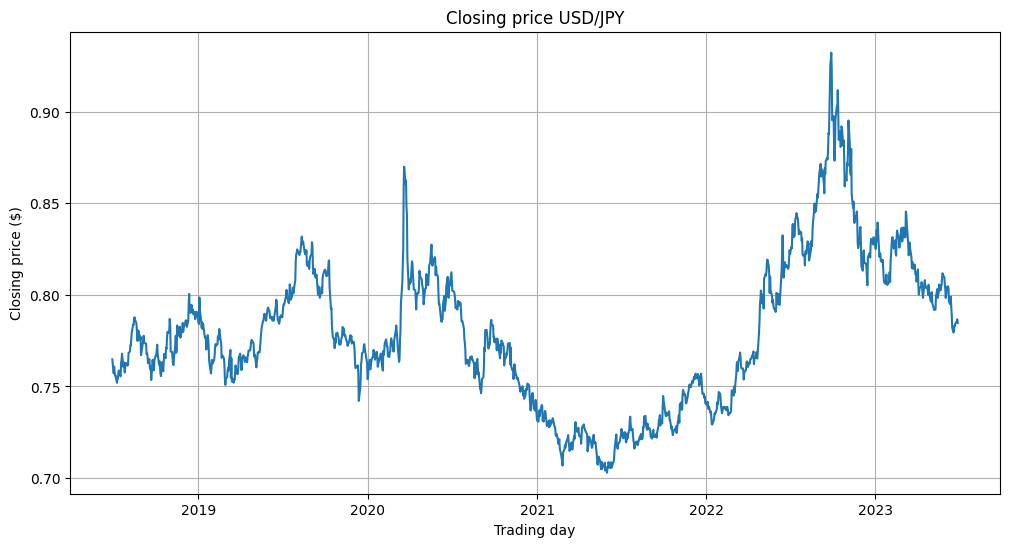

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.Close)
plt.title('Closing price USD/JPY')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(True)
plt.show()

In [ ]:
y = data['Close']

In [ ]:
y.head()

Date
2018-06-29    0.76481
2018-07-02    0.75713
2018-07-03    0.76080
2018-07-04    0.75790
2018-07-05    0.75590
Name: Close, dtype: float64

In [ ]:
# Split the data into train and test. Last 11 months to predict for testing and the rest of data from beginning for training
y_train = y['2018-06-28':'2021-06-27']
y_test = y['2021-06-28':'2023-06-28']

<Axes: xlabel='Date'>

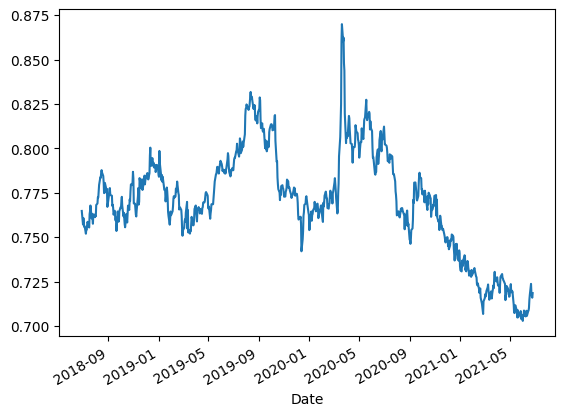

In [ ]:
y_train.plot()

<Axes: xlabel='Date'>

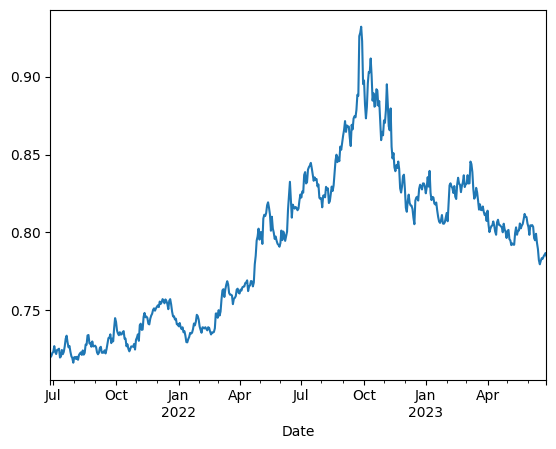

In [ ]:
y_test.plot()

### Augmented Dickey-Fuller (ADF) test
The ADF test is a statistical test used to determine if a time series is stationary or not.

In [ ]:
result = adfuller(y_train)
#  Augmented Dickey-Fuller (ADF) test
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.622596
p-value: 0.471368
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


`ADF statistic` value is -1.622596. To assess stationarity, we compare this value with the critical values.

`p-value` is a measure of the statistical significance of the ADF test. In this case, the p-value is 0.471368. To determine stationarity, we compare this value with a significance level, commonly 0.05. If the p-value is less than the significance level (e.g., p-value < 0.05), we reject the null hypothesis of non-stationarity.

`Critical Values`:
These values represent the thresholds for the ADF statistic at different confidence levels. We compare the ADF statistic with these critical values to determine if it falls within the range of rejection or acceptance of the null hypothesis.
- `1%: -3.439` The critical value at a 1% significance level is -3.439. If the ADF statistic is more negative than this critical value, it provides evidence against the null hypothesis of non-stationarity at the 1% significance level.

`5%: -2.865` The critical value at a 5% significance level is -2.865. If the ADF statistic is more negative than this critical value, it suggests evidence against non-stationarity at the 5% significance level.

`10%: -2.569` The critical value at a 10% significance level is -2.569. If the ADF statistic is more negative than this critical value, it indicates evidence against non-stationarity at the 10% significance level.

If the ADF statistic is more negative than the critical values (e.g., ADF statistic < -3.439 at 1% level, < -2.865 at 5% level, < -2.569 at 10% level), we have evidence to reject the null hypothesis of non-stationarity and conclude that the time series is **stationary**.
If the p-value is less than the significance level (e.g., p-value < 0.05), we can reject the null hypothesis of non-stationarity and infer stationarity.

###Hurst exponent
Hurst exponent is a measure of long-term memory or dependence in a time series. It characterizes the tendency of a time series to exhibit persistence or mean reversion.

where values closer to 0.5 indicate a random or uncorrelated series, values greater than 0.5 suggest positive autocorrelation or persistence, and values less than 0.5 indicate negative autocorrelation or mean reversion.

The coefficient (c) provides additional information about the estimation error and scaling properties of the time series.

In [ ]:
!pip install hurst
import hurst
#calculate the Hurst exponent (H), the coefficient (c), and also returns the data used for the calculation (data) based on the y_train time series.
H, c,data = hurst.compute_Hc(y_train)
print("H = {:.4f}, c = {:.4f}".format(H,c))

H = 0.4916, c = 1.3691


Hurst exponent (H) is 0.4916, which suggests that the time series exhibits some degree of persistence or positive autocorrelation.

### ACF and PACF
Autocorrelation Function (ACF):
The ACF measures the correlation between a time series and its lagged values. It calculates the correlation coefficient for each lagged value up to a specified number of lags. The ACF plot represents the correlation coefficients on the y-axis against the lag values on the x-axis.

The ACF helps identify the presence of autocorrelation in a time series. Autocorrelation occurs when there is a relationship between the values of a series and its past values. The ACF can help determine the order of autoregressive (AR) terms in an ARIMA model. In the ACF plot, significant values outside the confidence interval suggest correlation at those lag values.

Partial Autocorrelation Function (PACF):
The PACF measures the correlation between a time series and its lagged values while controlling for the effects of intermediate lags. It helps identify the direct relationship between a value and its lagged values without the influence of intermediate observations.

The PACF plot shows the correlation coefficients on the y-axis against the lag values on the x-axis. It is useful in identifying the order of the moving average (MA) terms in an ARIMA model. Significant values outside the confidence interval in the PACF plot suggest the presence of correlation at those lag values.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

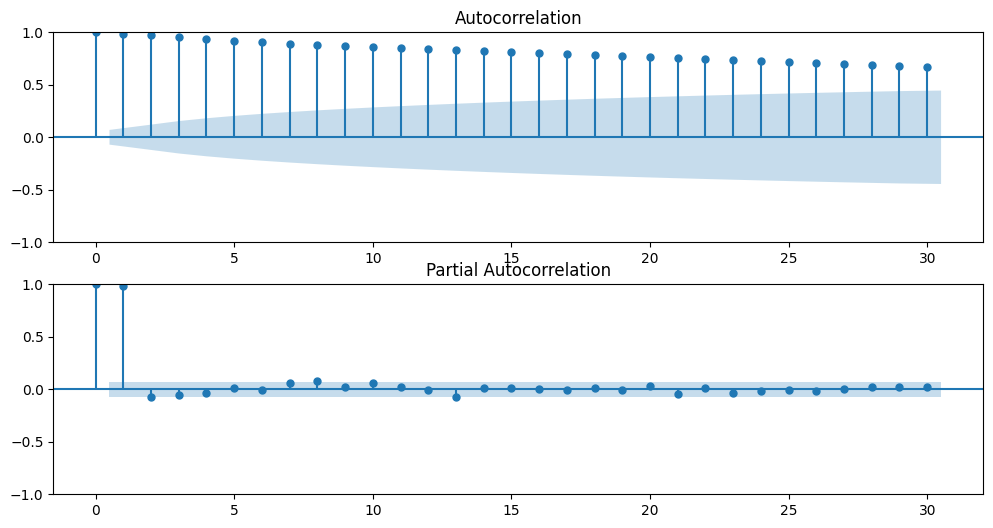

In [ ]:
fig, ax = plt.subplots(2, figsize = (12,6))
ax[0] = plot_acf(y_train, ax=ax[0], lags=30)
ax[1] = plot_pacf(y_train, ax=ax[1], lags=30)

## Time series Decomposition
Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.
### Time series components
A given time series is thought to consist of three systematic components (can be modeled) including level, trend, seasonality, and one non-systematic (cannot be directly modeled) component called noise.

`Level`: The average value in the series.
`Trend`: The increasing or decreasing value in the series.
`Seasonality`: The repeating short-term cycle in the series.
`Noise`: The random variation in the series.

In [ ]:
import statsmodels.api as sm

In [ ]:
print(type(y_train))
print(y_train.index)

<class 'pandas.core.series.Series'>
DatetimeIndex(['2018-06-29', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12',
               ...
               '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17',
               '2021-06-18', '2021-06-21', '2021-06-22', '2021-06-23',
               '2021-06-24', '2021-06-25'],
              dtype='datetime64[ns]', name='Date', length=780, freq=None)


In [ ]:
y_train = y_train.asfreq('M')

In [ ]:
y_train = y_train.dropna()

y_train series does not have a frequency set (freq=None), you can explicitly specify the period parameter when calling the seasonal_decompose function. The period should reflect the seasonality of your data.

For example, if your data has a monthly frequency, you can set period=12 for annual seasonality:

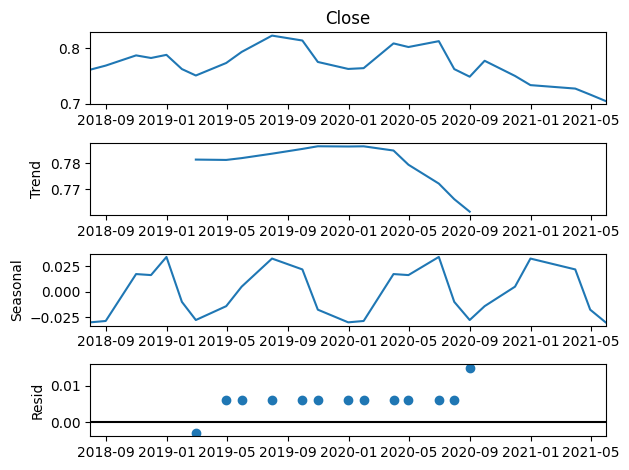

In [ ]:
ts_decomp = sm.tsa.seasonal_decompose(y_train, model='additive', period=12)
ts_decomp.plot()
plt.show()


The first one is "Observed or True" values. Trend is not specific. Seasonality shows homogeneous peaks during the time and same as true values. Since we have strong seasonality, we use seasonal Arima instead of just Arima.

### SARIMA
SARIMA, which stands for Seasonal Autoregressive Integrated Moving Average, is a widely used time series forecasting model that extends the ARIMA model to incorporate seasonal components. It is useful for analyzing and forecasting data with seasonal patterns.

SARIMA models require selecting appropriate orders for the non-seasonal and seasonal components, typically determined through methods like autocorrelation function (ACF) and partial autocorrelation function (PACF) analysis. These orders determine the number of autoregressive, differencing, and moving average terms used in the model.

By considering both the non-seasonal and seasonal components, SARIMA models can effectively capture and forecast complex time series patterns. However, selecting the optimal SARIMA model requires careful analysis, parameter tuning, and validation to ensure accurate and reliable forecasts.

First, defined and assigned a value to the best_model variable before trying to access its attributes, such as summary().

In [ ]:
import statsmodels.api as sm
from itertools import product

# Perform SARIMA model selection and evaluation
# (Code for model selection goes here)

# After selecting the best model, assign it to the variable best_model
best_model = sm.tsa.SARIMAX(y_train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12)).fit()

# Print the best model's summary
print("Best Model Summary:")
print(best_model.summary())

Best Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                  31.271
Date:                            Fri, 30 Jun 2023   AIC                            -52.543
Time:                                    02:04:07   BIC                            -49.718
Sample:                                         0   HQIC                           -53.124
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7536      0.389      1.939      0.053      -0.008       1.515
ma.L1          

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   25
Model:                        SARIMAX   Log Likelihood                 -28.954
Date:                Fri, 30 Jun 2023   AIC                             59.909
Time:                        02:04:07   BIC                             61.128
Sample:                             0   HQIC                            60.247
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5936      3.104      0.191      0.848      -5.490       6.677
Ljung-Box (L1) (Q):                  11.48   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.00   Pr

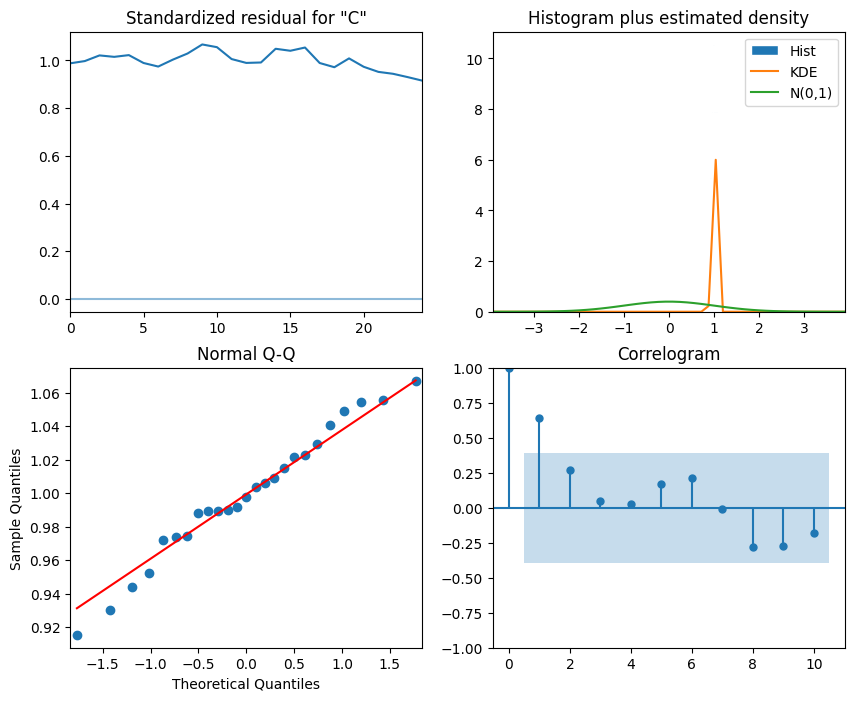

                                 SARIMAX Results                                  
Dep. Variable:                      Close   No. Observations:                   25
Model:             SARIMAX(0, 0, [1], 12)   Log Likelihood                 -21.942
Date:                    Fri, 30 Jun 2023   AIC                             47.883
Time:                            02:04:08   BIC                             50.321
Sample:                                 0   HQIC                            48.559
                                     - 25                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.9998   3820.148      0.000      1.000   -7486.352    7488.352
sigma2         0.1977    754.942      0.000      1.000   -1479.462    1479.857
Ljung-Box (L1) (Q): 

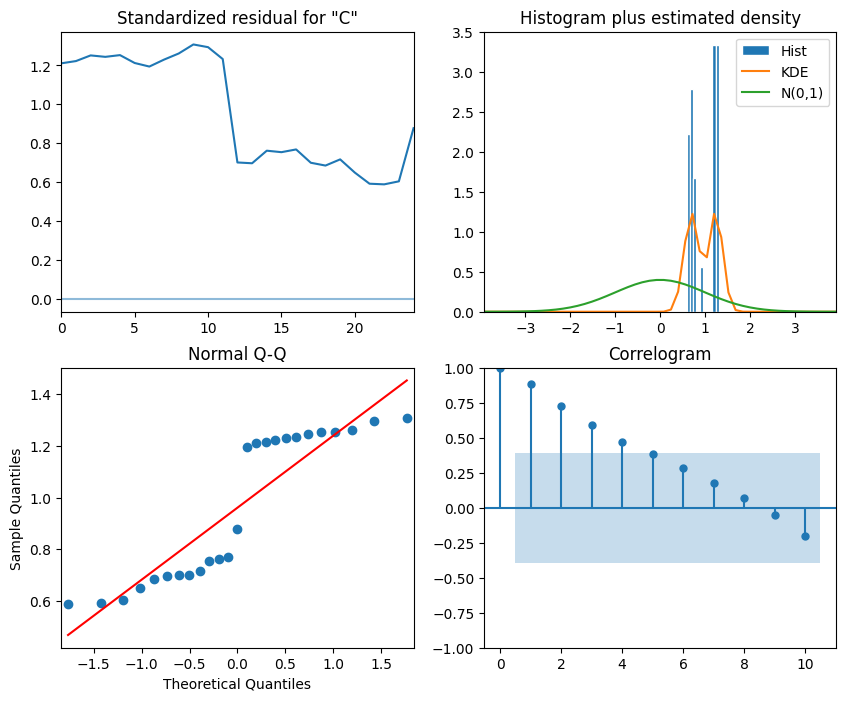

                                SARIMAX Results                                 
Dep. Variable:                    Close   No. Observations:                   25
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                  22.129
Date:                  Fri, 30 Jun 2023   AIC                            -42.257
Time:                          02:04:09   BIC                            -41.692
Sample:                               0   HQIC                           -42.374
                                   - 25                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0019      0.001      2.490      0.013       0.000       0.003
Ljung-Box (L1) (Q):                  10.15   Jarque-Bera (JB):                 1.42
Prob(Q):                       

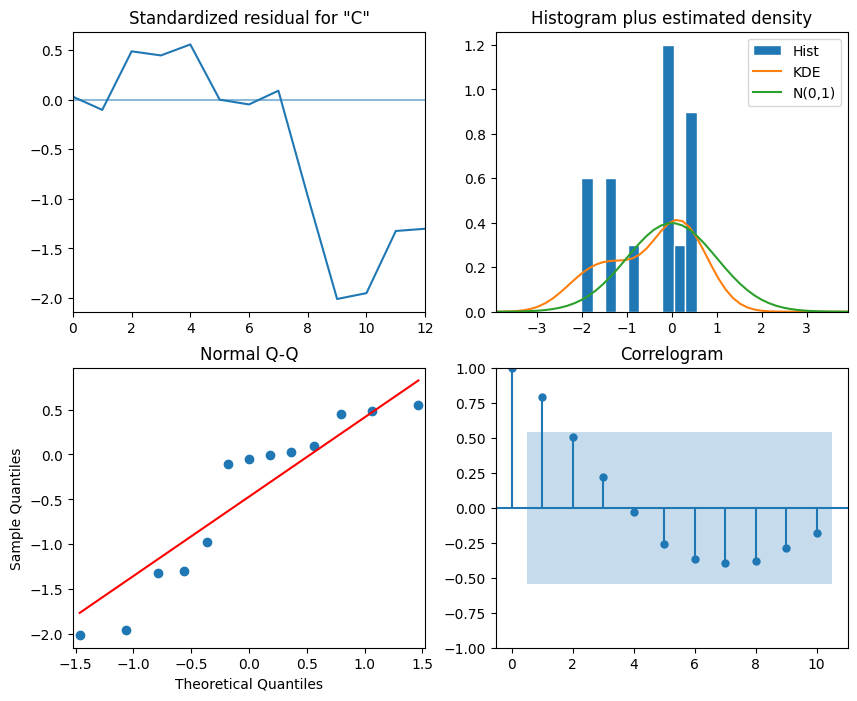

                                 SARIMAX Results                                  
Dep. Variable:                      Close   No. Observations:                   25
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                  22.129
Date:                    Fri, 30 Jun 2023   AIC                            -40.257
Time:                            02:04:10   BIC                            -39.128
Sample:                                 0   HQIC                           -40.490
                                     - 25                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12   -1.257e-05     26.327  -4.77e-07      1.000     -51.600      51.600
sigma2         0.0019      0.001      2.465      0.014       0.000       0.003
Ljung-Box (L1) (Q): 

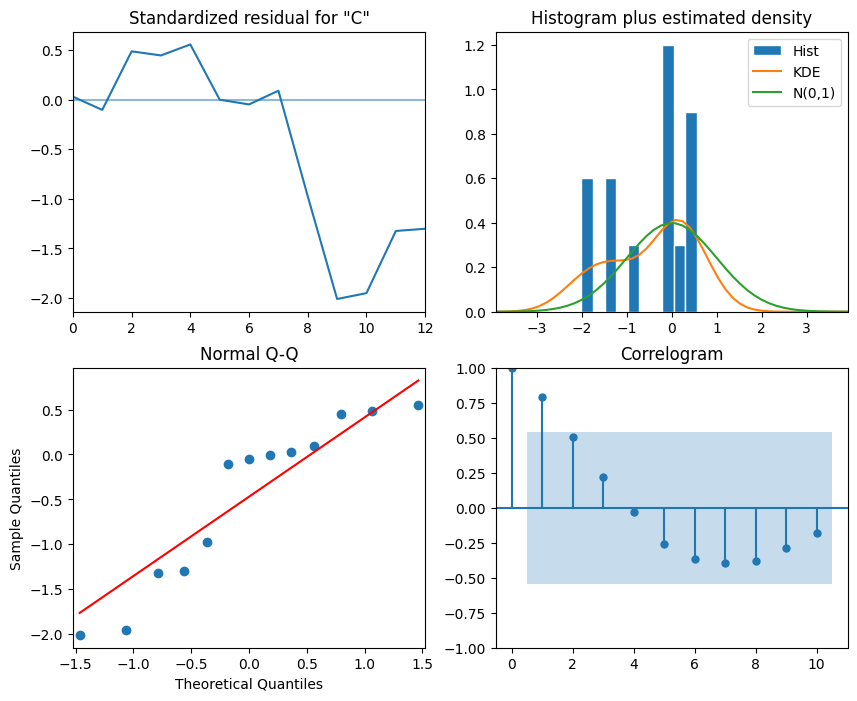

                                SARIMAX Results                                 
Dep. Variable:                    Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                   8.231
Date:                  Fri, 30 Jun 2023   AIC                            -12.462
Time:                          02:04:12   BIC                            -10.024
Sample:                               0   HQIC                           -11.786
                                   - 25                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9984      0.013     76.215      0.000       0.973       1.024
sigma2         0.0019      0.001      2.017      0.044    5.49e-05       0.004
Ljung-Box (L1) (Q):                 

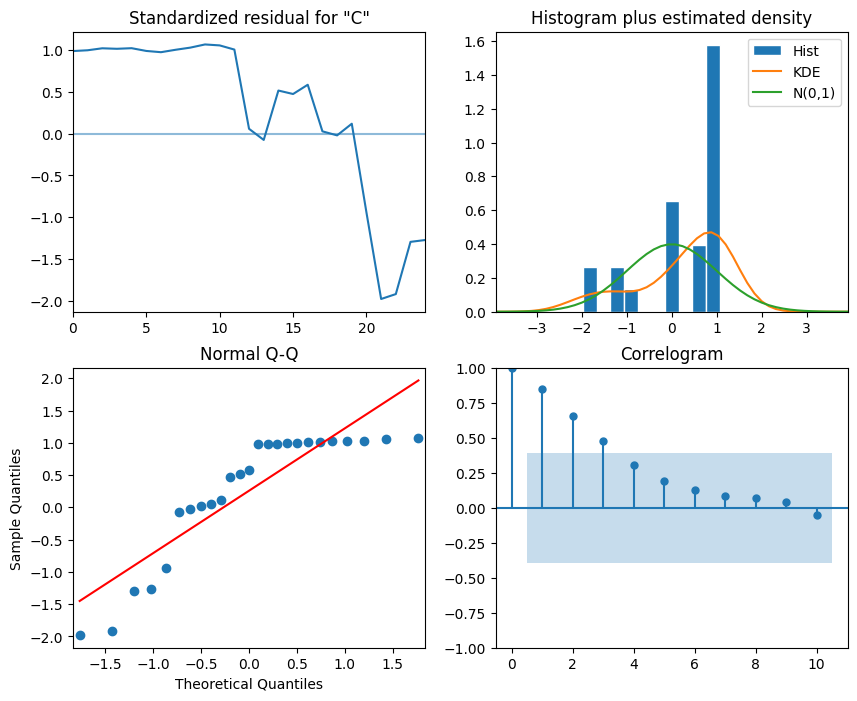

                                 SARIMAX Results                                  
Dep. Variable:                      Close   No. Observations:                   25
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                   8.231
Date:                    Fri, 30 Jun 2023   AIC                            -10.462
Time:                            02:04:14   BIC                             -6.805
Sample:                                 0   HQIC                            -9.447
                                     - 25                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9984      0.022     45.169      0.000       0.955       1.042
ma.S.L12      -0.0023      2.905     -0.001      0.999      -5.695       5.691
sigma2         0.001

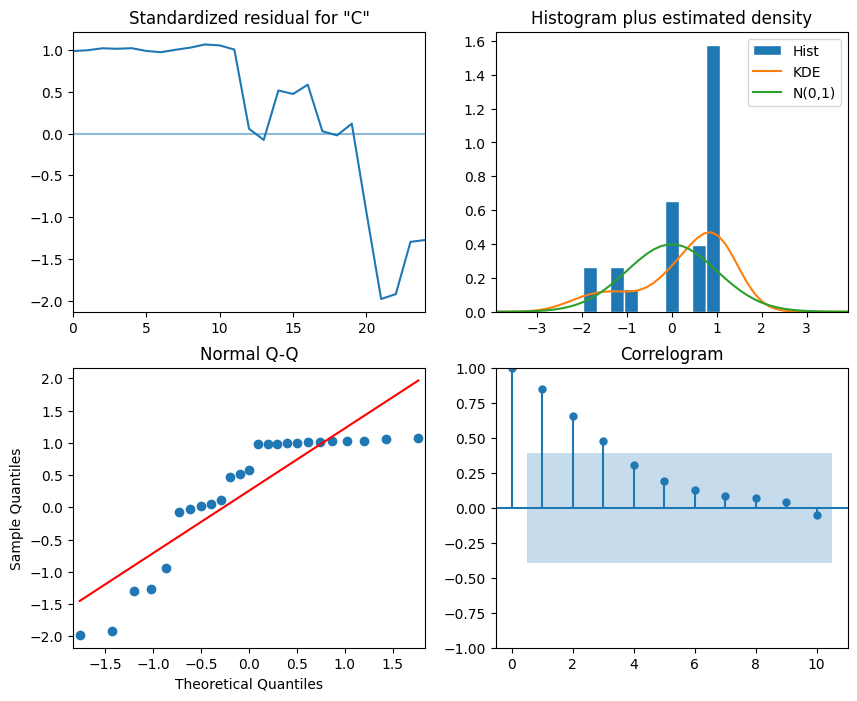

                                SARIMAX Results                                 
Dep. Variable:                    Close   No. Observations:                   25
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                  22.130
Date:                  Fri, 30 Jun 2023   AIC                            -40.260
Time:                          02:04:15   BIC                            -39.130
Sample:                               0   HQIC                           -40.492
                                   - 25                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0559   1852.846  -3.02e-05      1.000   -3631.567    3631.455
sigma2         0.0019      0.403      0.005      0.996      -0.787       0.791
Ljung-Box (L1) (Q):                 

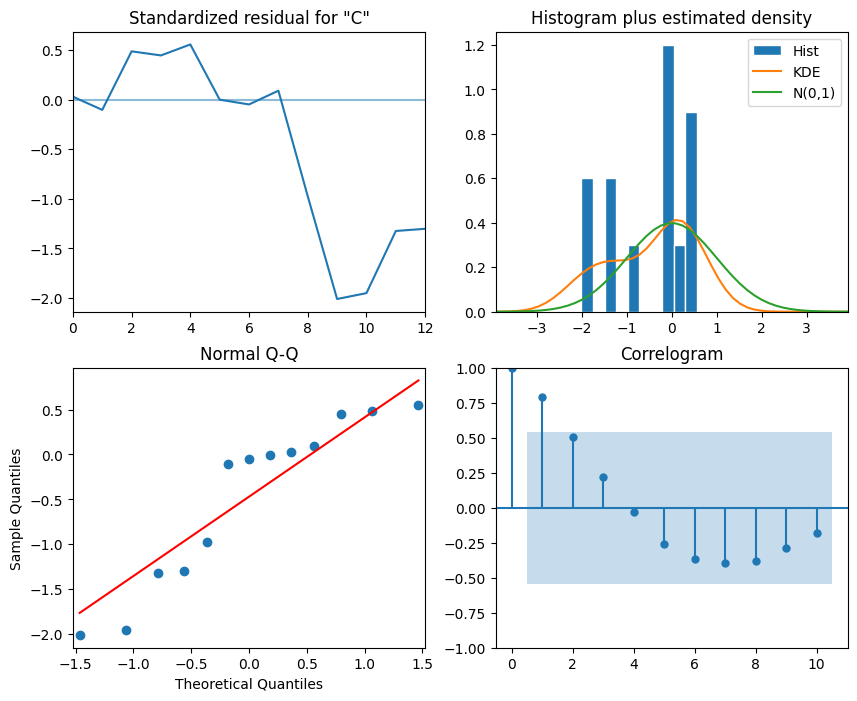

                                 SARIMAX Results                                  
Dep. Variable:                      Close   No. Observations:                   25
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                  22.130
Date:                    Fri, 30 Jun 2023   AIC                            -38.260
Time:                            02:04:16   BIC                            -36.565
Sample:                                 0   HQIC                           -38.608
                                     - 25                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0276   1.67e-07  -1.66e+05      0.000      -0.028      -0.028
ma.S.L12      -0.0276   1.66e-07  -1.66e+05      0.000      -0.028      -0.028
sigma2         0.001

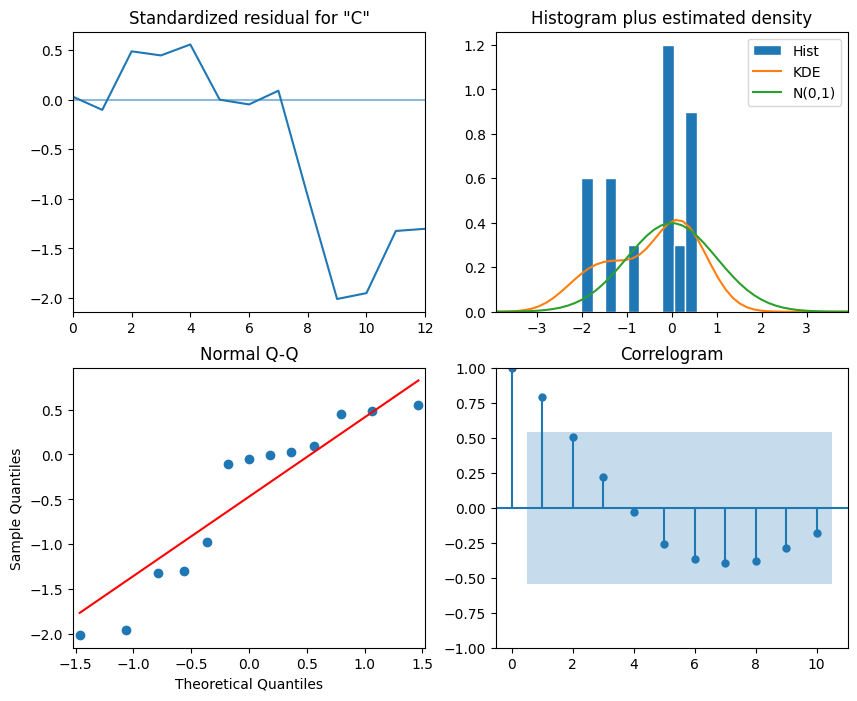

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   25
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -13.772
Date:                Fri, 30 Jun 2023   AIC                             31.544
Time:                        02:04:17   BIC                             33.982
Sample:                             0   HQIC                            32.220
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9998    191.361      0.005      0.996    -374.061     376.061
sigma2         0.1547     29.493      0.005      0.996     -57.650      57.960
Ljung-Box (L1) (Q):                   9.49   Jarque-

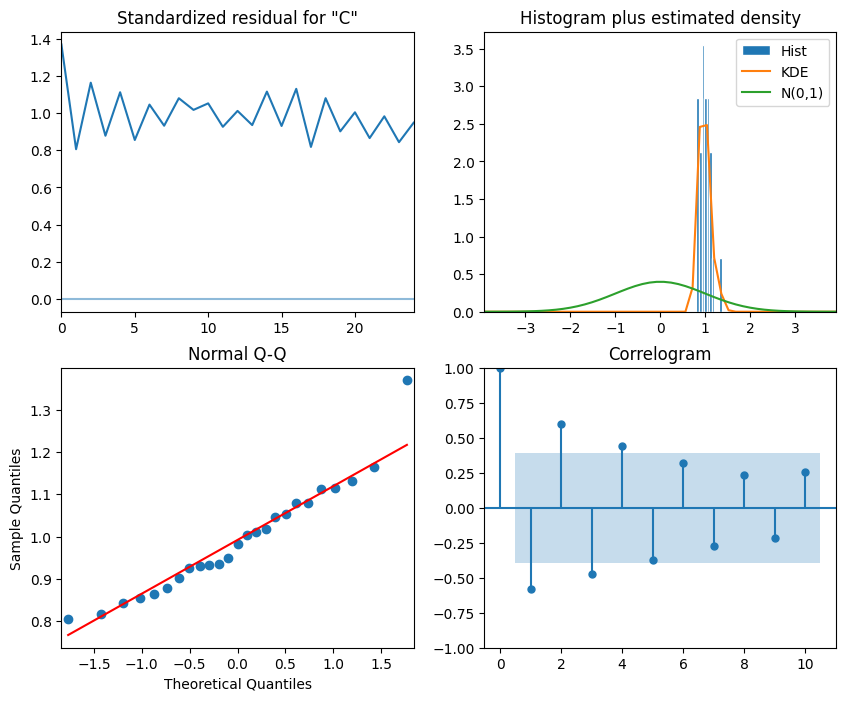

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                  -6.354
Date:                            Fri, 30 Jun 2023   AIC                             18.709
Time:                                    02:04:19   BIC                             22.365
Sample:                                         0   HQIC                            19.723
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0000   1113.726      0.001      0.999   -2181.863    2183.863
ma.S.L12       0.9999   8550.816   

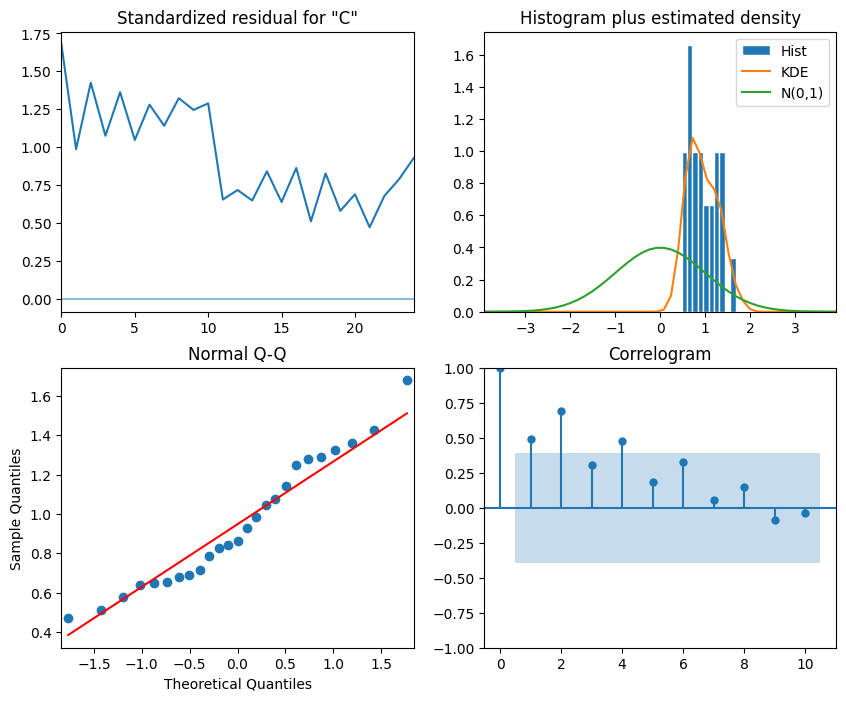

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   25
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                  27.990
Date:                             Fri, 30 Jun 2023   AIC                            -51.980
Time:                                     02:04:20   BIC                            -50.850
Sample:                                          0   HQIC                           -52.212
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9457      0.736      1.285      0.199      -0.496       2.388
sigma2         0.0007      

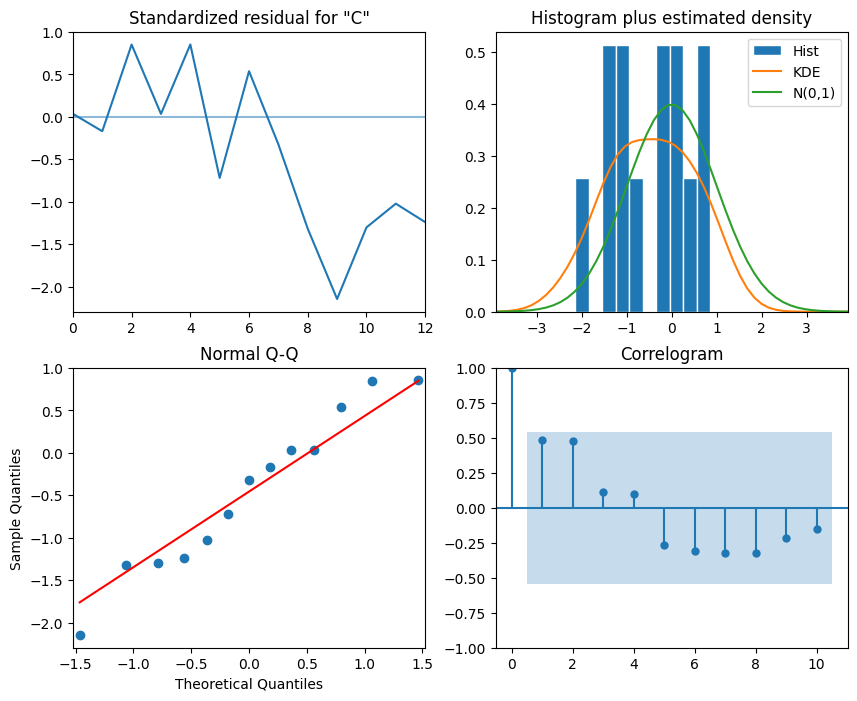

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  27.943
Date:                            Fri, 30 Jun 2023   AIC                            -49.885
Time:                                    02:04:22   BIC                            -48.190
Sample:                                         0   HQIC                           -50.233
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9149      0.567      1.614      0.106      -0.196       2.026
ma.S.L12      -0.0484      1.143   

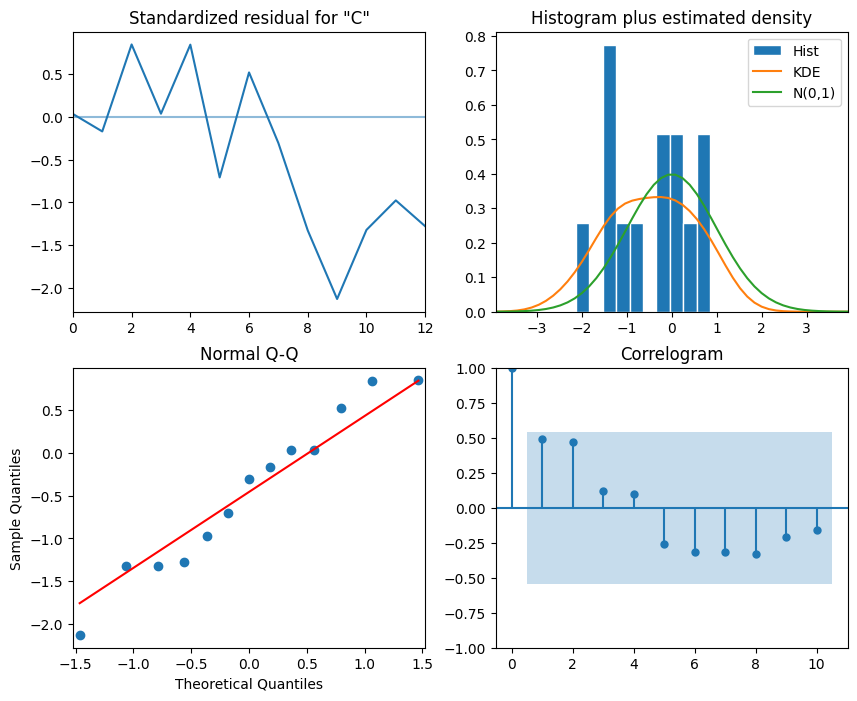

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   25
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                  19.876
Date:                             Fri, 30 Jun 2023   AIC                            -33.751
Time:                                     02:04:24   BIC                            -30.095
Sample:                                          0   HQIC                           -32.737
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9997      0.079     12.680      0.000       0.845       1.154
ar.S.L12       0.9960      

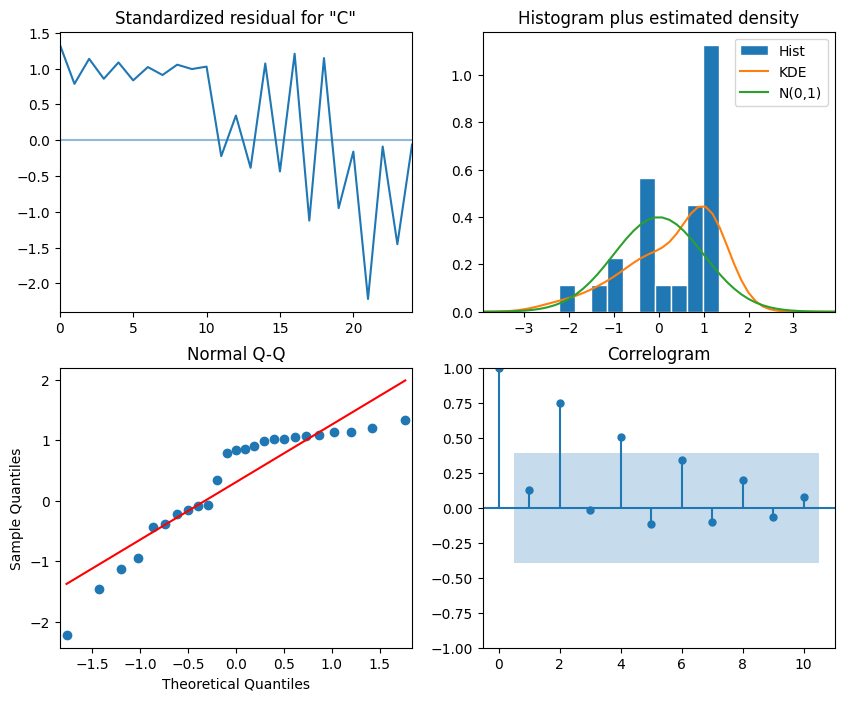

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                  23.260
Date:                            Fri, 30 Jun 2023   AIC                            -38.519
Time:                                    02:04:25   BIC                            -33.644
Sample:                                         0   HQIC                           -37.167
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9813      0.033     29.704      0.000       0.917       1.046
ar.S.L12       0.9956      0.009   

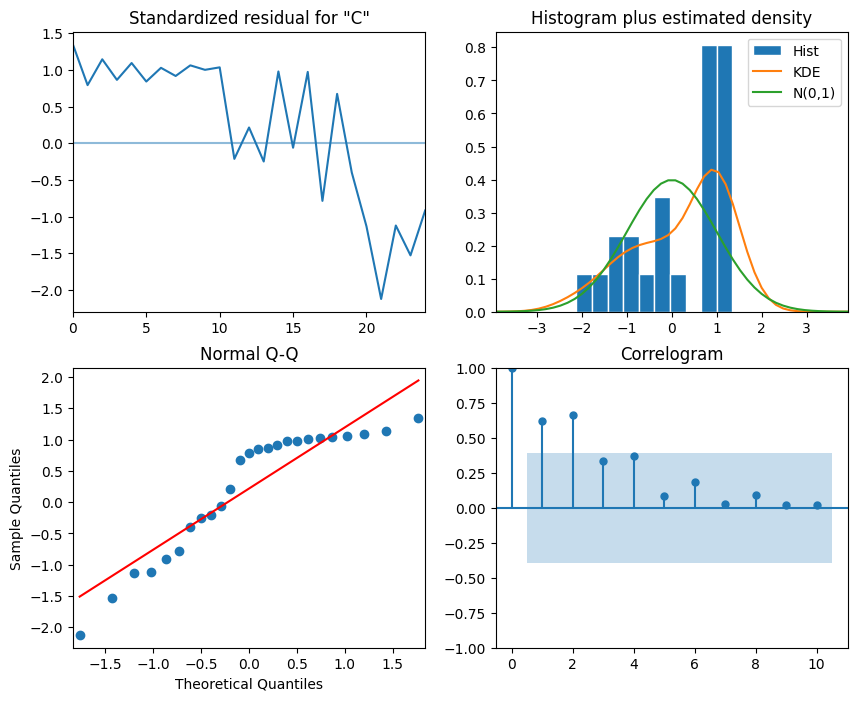

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   25
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                  27.934
Date:                             Fri, 30 Jun 2023   AIC                            -49.868
Time:                                     02:04:27   BIC                            -48.173
Sample:                                          0   HQIC                           -50.216
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9028      0.501      1.801      0.072      -0.080       1.885
ar.S.L12       0.0856      

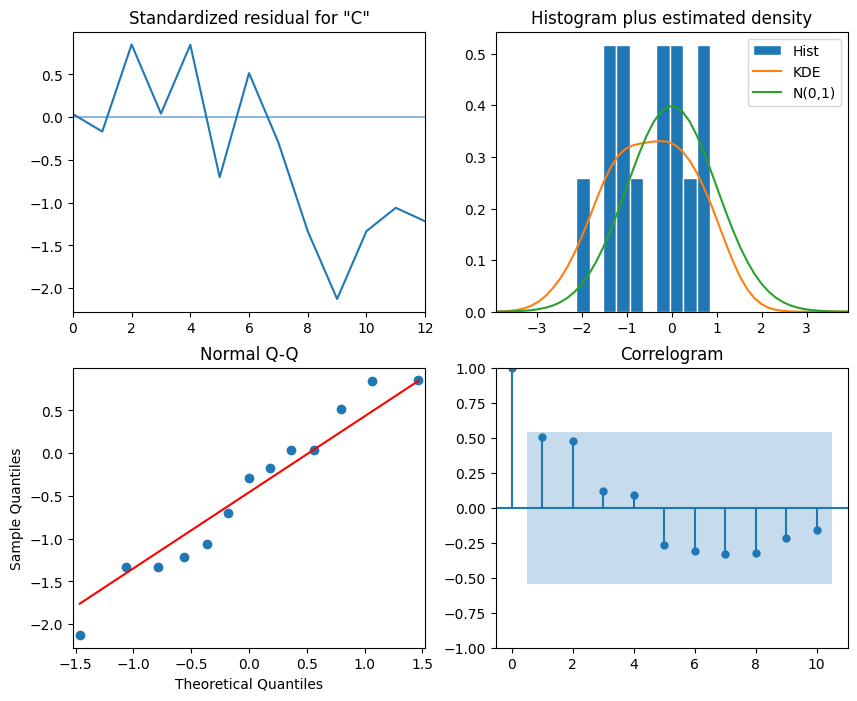

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                  27.978
Date:                            Fri, 30 Jun 2023   AIC                            -47.956
Time:                                    02:04:29   BIC                            -45.696
Sample:                                         0   HQIC                           -48.420
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9306      0.660      1.411      0.158      -0.362       2.223
ar.S.L12       0.0597      0.604   

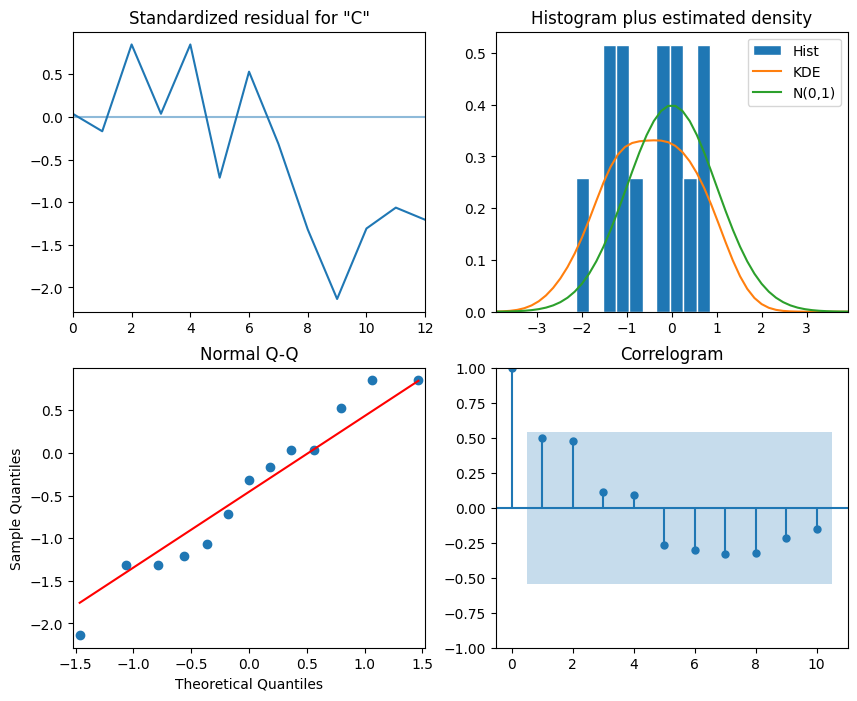

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   25
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  57.586
Date:                Fri, 30 Jun 2023   AIC                           -113.171
Time:                        02:04:30   BIC                           -111.993
Sample:                             0   HQIC                          -112.859
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005      0.000      3.236      0.001       0.000       0.001
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.72   Pr

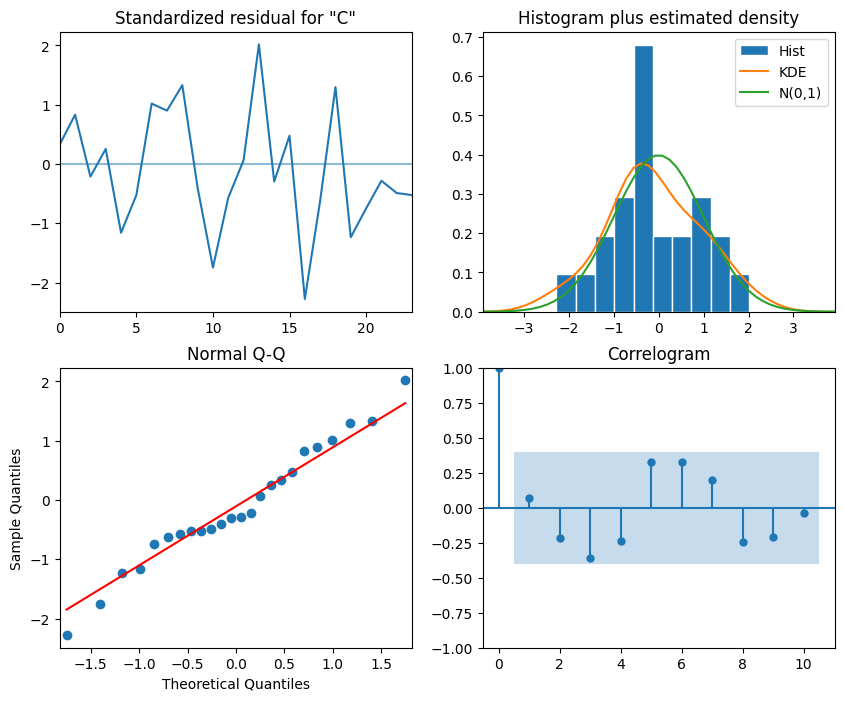

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   25
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                  58.901
Date:                              Fri, 30 Jun 2023   AIC                           -113.802
Time:                                      02:04:31   BIC                           -111.446
Sample:                                           0   HQIC                          -113.177
                                               - 25                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.6074      0.669      0.908      0.364      -0.703       1.918
sigma2         0.00

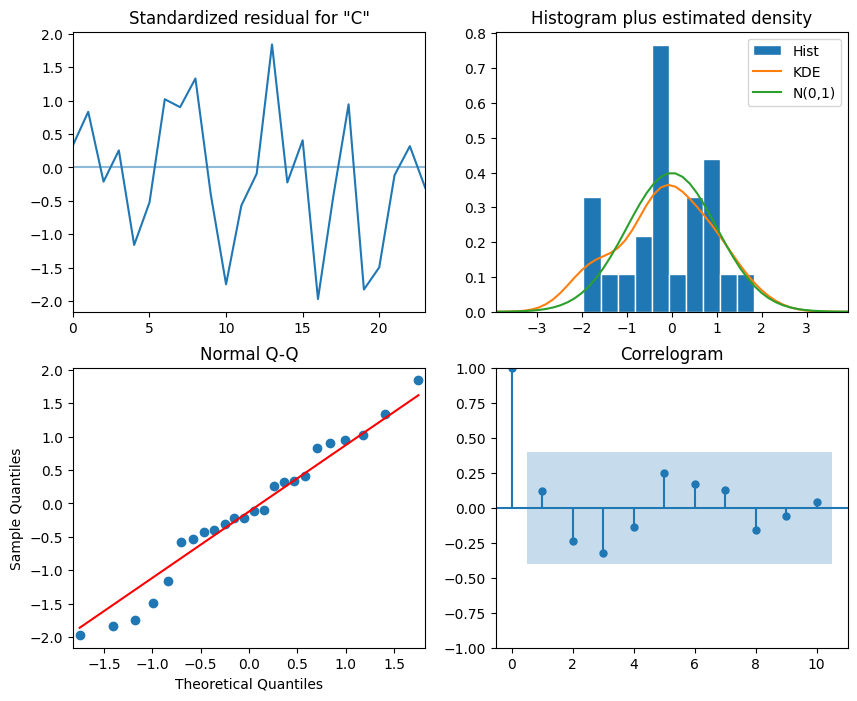

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  28.153
Date:                            Fri, 30 Jun 2023   AIC                            -54.306
Time:                                    02:04:33   BIC                            -53.821
Sample:                                         0   HQIC                           -54.485
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005      0.000      2.491      0.013       0.000       0.001
Ljung-Box (L1) (Q):                

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

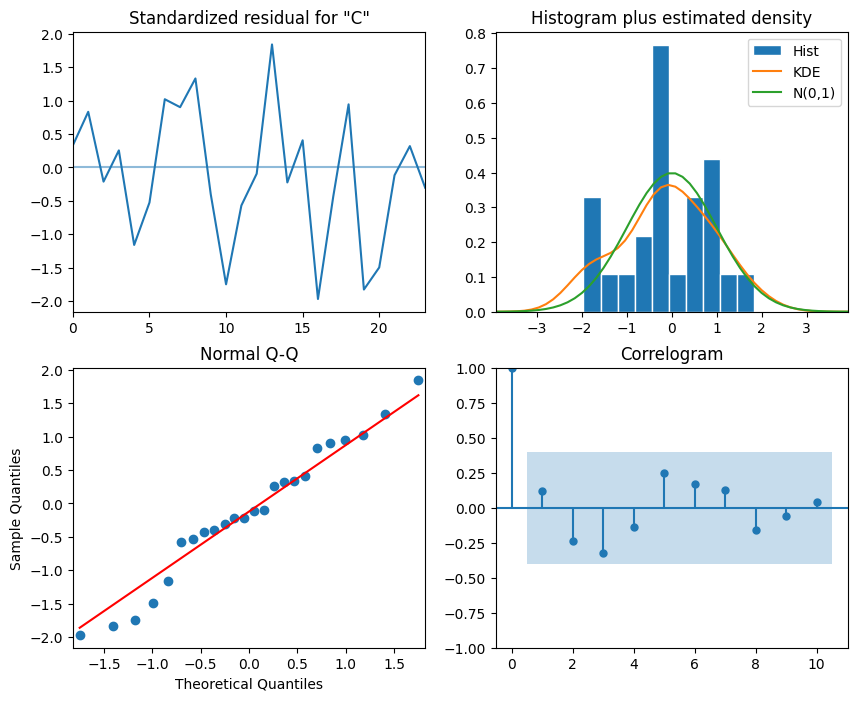

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   25
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                  58.901
Date:                              Fri, 30 Jun 2023   AIC                           -111.802
Time:                                      02:04:34   BIC                           -108.268
Sample:                                           0   HQIC                          -110.865
                                               - 25                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2474      0.173      1.428      0.153      -0.092       0.587
ma.S.L12       0.24

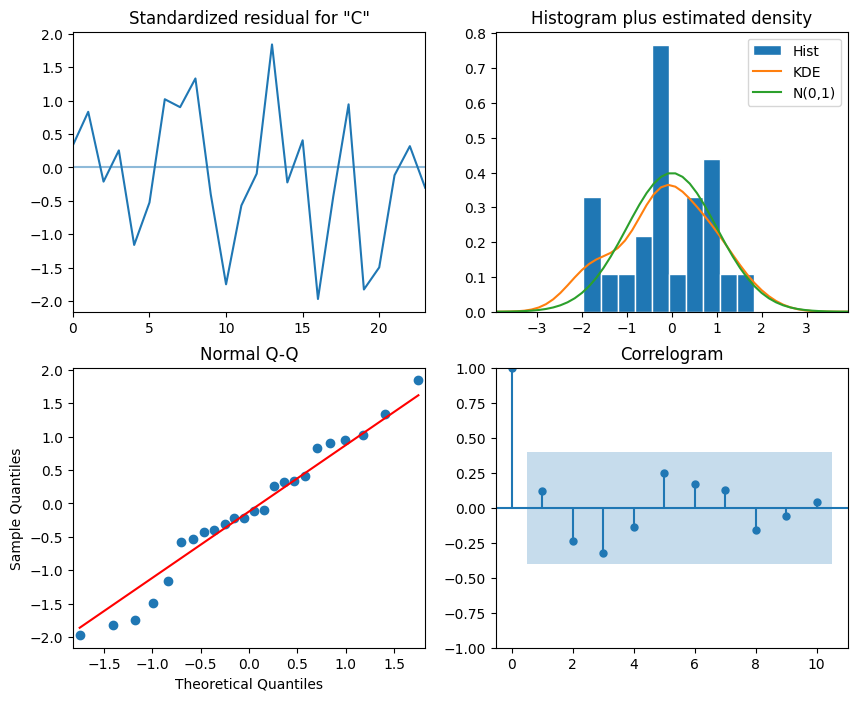

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  28.153
Date:                            Fri, 30 Jun 2023   AIC                            -52.306
Time:                                    02:04:36   BIC                            -51.336
Sample:                                         0   HQIC                           -52.665
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12    1.907e-07    4.4e-14   4.33e+06      0.000    1.91e-07    1.91e-07
sigma2         0.0005      0.000   

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

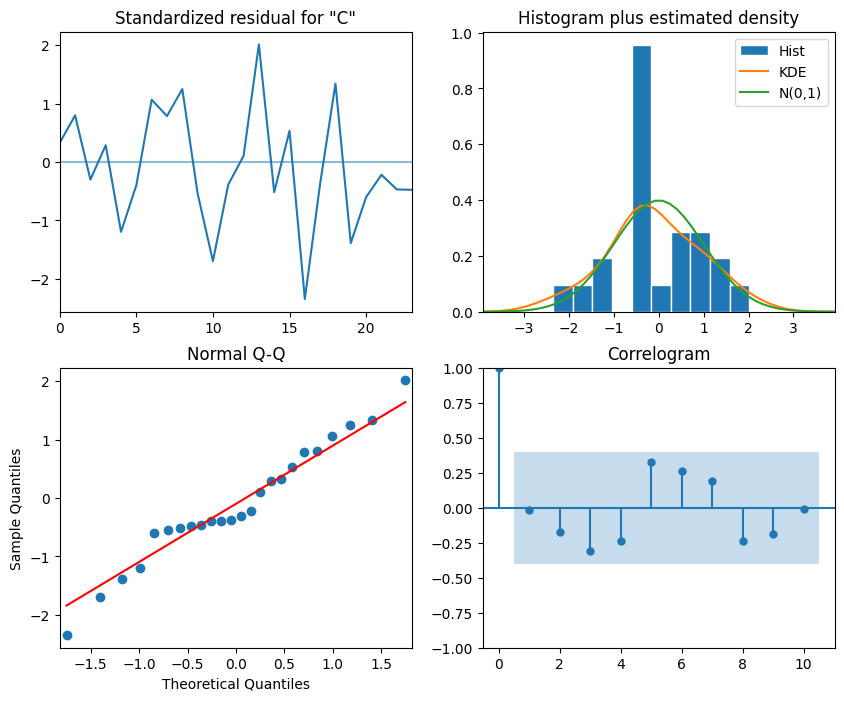

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                  59.227
Date:                            Fri, 30 Jun 2023   AIC                           -112.455
Time:                                    02:04:38   BIC                           -108.921
Sample:                                         0   HQIC                          -111.517
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1940      0.245      0.791      0.429      -0.287       0.675
ma.S.L12       0.7538      1.366   

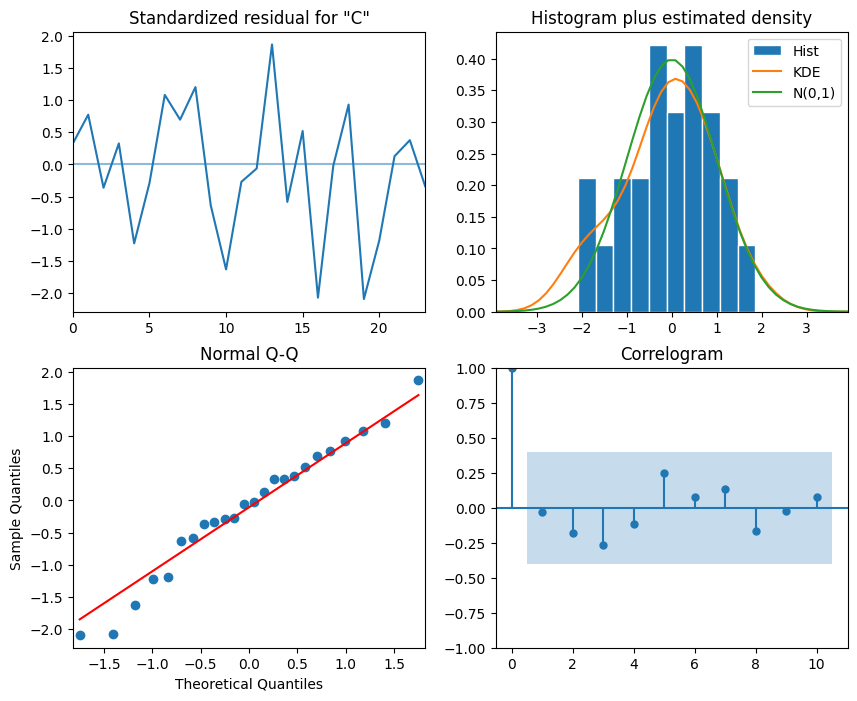

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   25
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                  28.798
Date:                             Fri, 30 Jun 2023   AIC                            -53.596
Time:                                     02:04:39   BIC                            -52.626
Sample:                                          0   HQIC                           -53.955
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4081      0.334      1.222      0.222      -0.246       1.063
sigma2         0.0005      

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

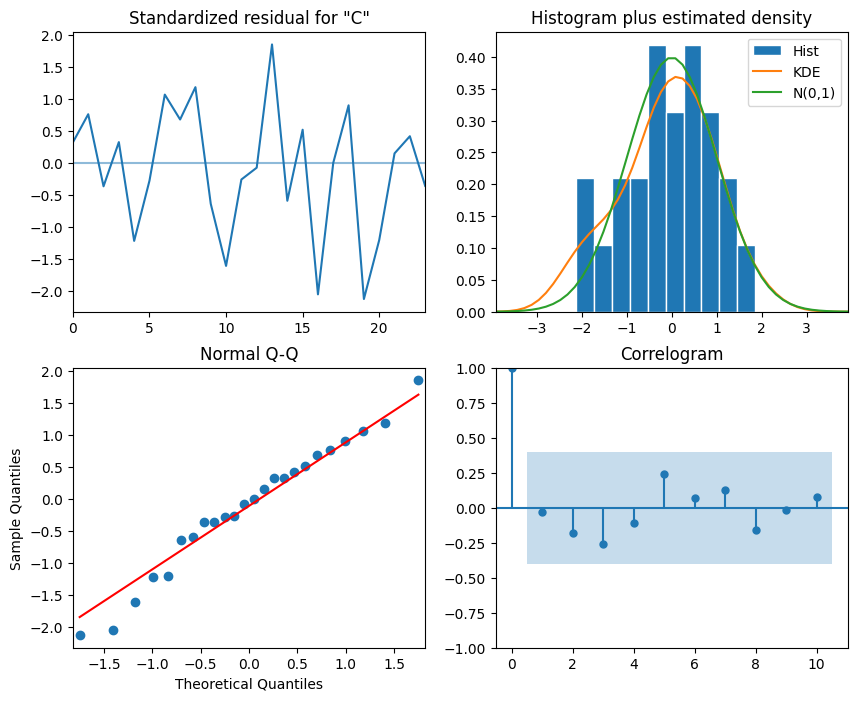

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                  59.222
Date:                            Fri, 30 Jun 2023   AIC                           -110.444
Time:                                    02:04:41   BIC                           -105.732
Sample:                                         0   HQIC                          -109.194
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1935      0.245      0.789      0.430      -0.287       0.674
ar.S.L12       0.2744     54.184   

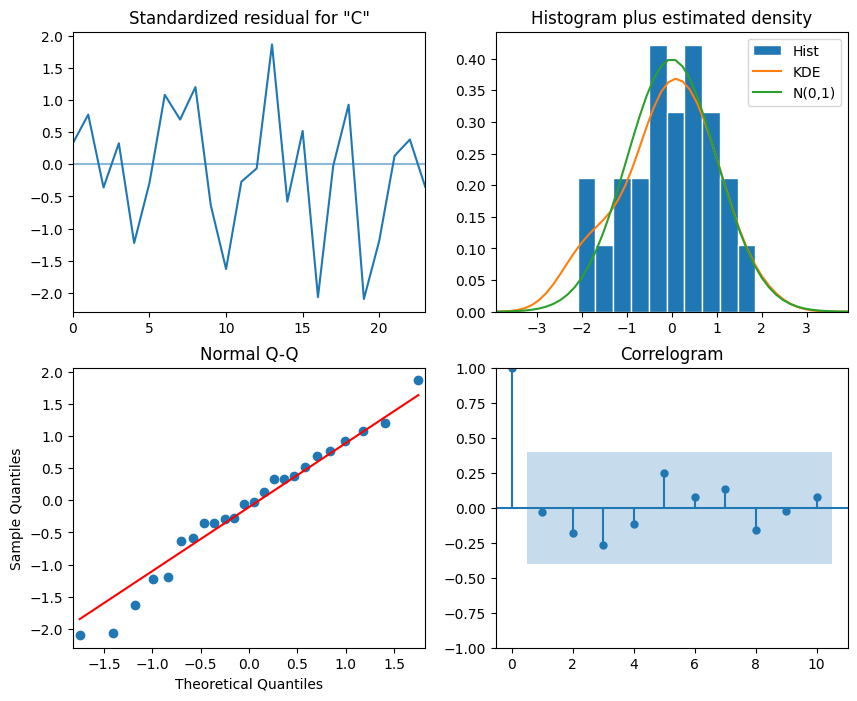

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   25
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                  28.841
Date:                             Fri, 30 Jun 2023   AIC                            -51.682
Time:                                     02:04:43   BIC                            -50.228
Sample:                                          0   HQIC                           -52.221
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5056      0.319      1.584      0.113      -0.120       1.131
ar.S.L12       0.4182      

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

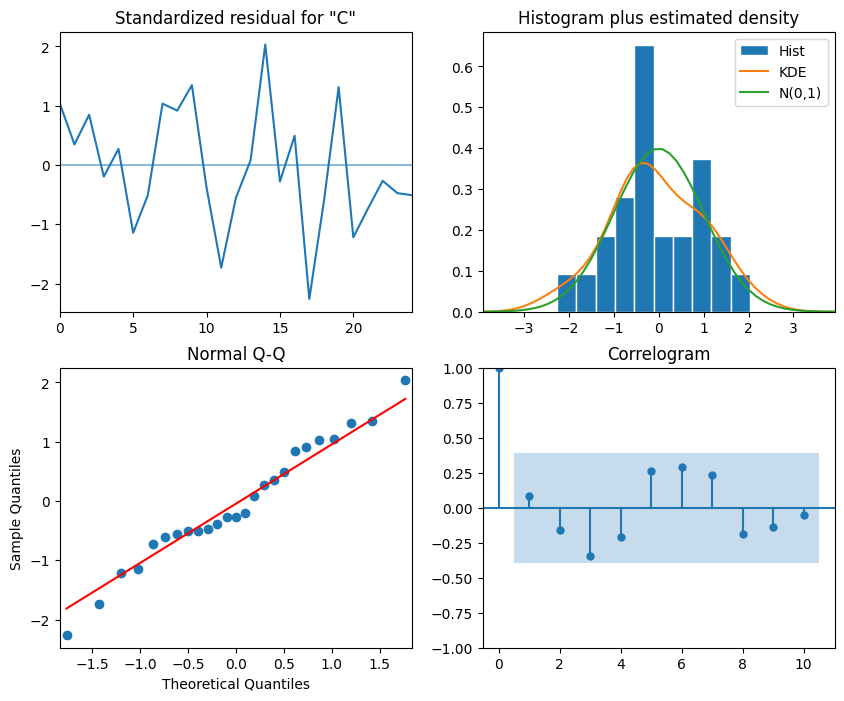

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                  57.807
Date:                              Fri, 30 Jun 2023   AIC                           -109.614
Time:                                      02:04:46   BIC                           -105.957
Sample:                                           0   HQIC                          -108.600
                                               - 25                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.007    144.759      0.000       0.985       1.013
ma.S.L12       1.00

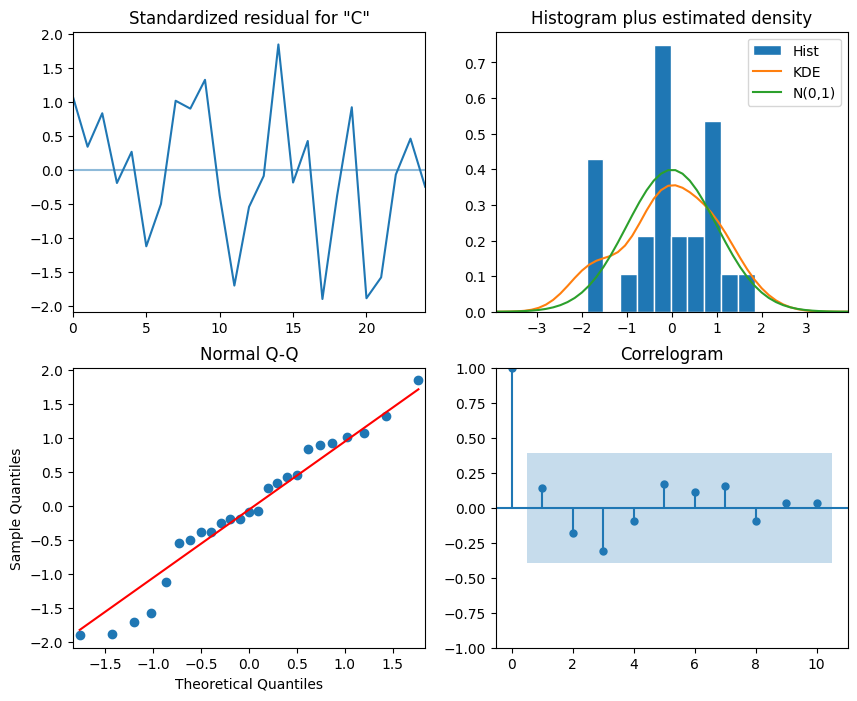

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                  30.356
Date:                            Fri, 30 Jun 2023   AIC                            -56.712
Time:                                    02:04:47   BIC                            -55.582
Sample:                                         0   HQIC                           -56.944
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8573      0.178      4.827      0.000       0.509       1.205
sigma2         0.0005      0.000   

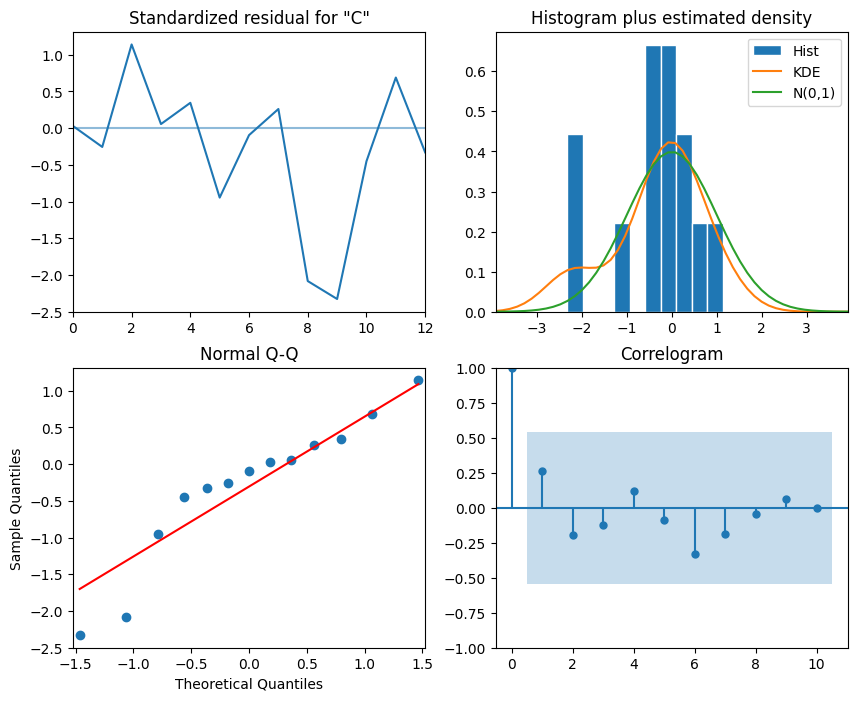

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                  30.373
Date:                              Fri, 30 Jun 2023   AIC                            -54.746
Time:                                      02:04:49   BIC                            -53.051
Sample:                                           0   HQIC                           -55.094
                                               - 25                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8986      0.677      1.328      0.184      -0.428       2.225
ma.S.L12      -0.52

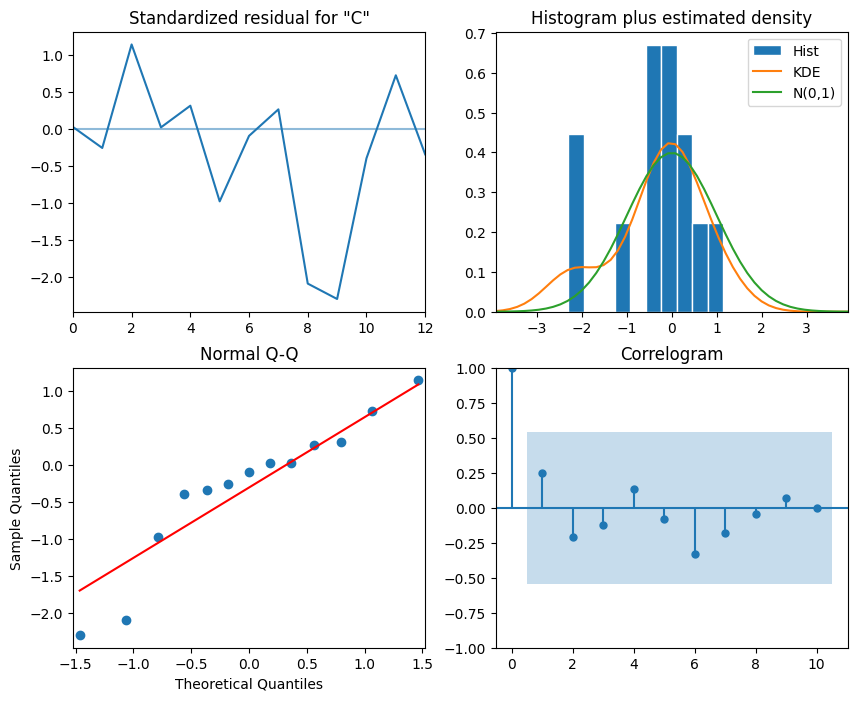

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                  57.834
Date:                            Fri, 30 Jun 2023   AIC                           -109.668
Time:                                    02:04:50   BIC                           -106.012
Sample:                                         0   HQIC                          -108.654
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9987      0.010    102.083      0.000       0.980       1.018
ar.S.L12       0.4531      0.236   

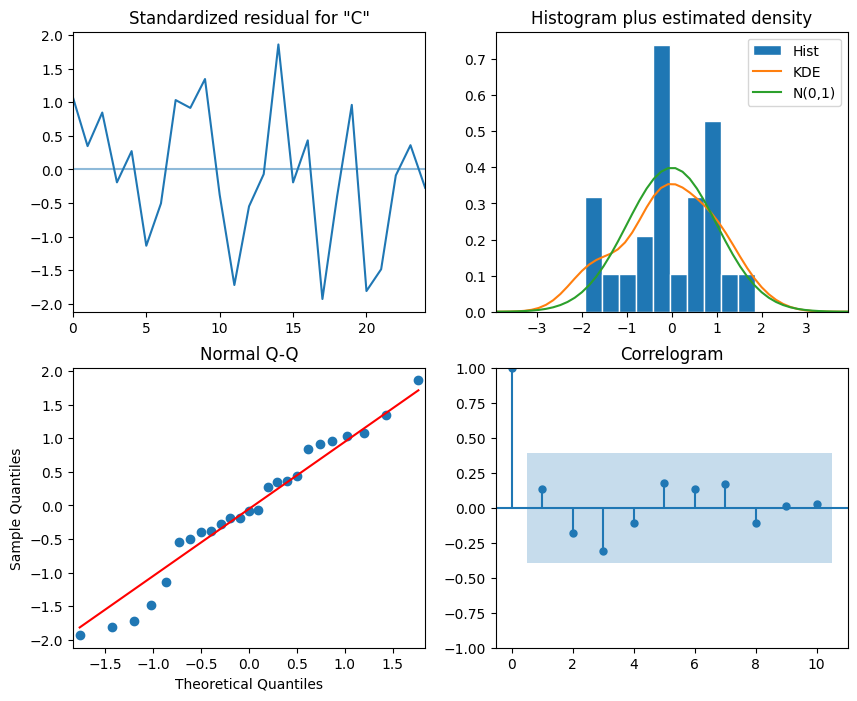

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                  57.880
Date:                              Fri, 30 Jun 2023   AIC                           -107.761
Time:                                      02:04:52   BIC                           -102.885
Sample:                                           0   HQIC                          -106.408
                                               - 25                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9971      0.028     35.510      0.000       0.942       1.052
ar.S.L12       0.88

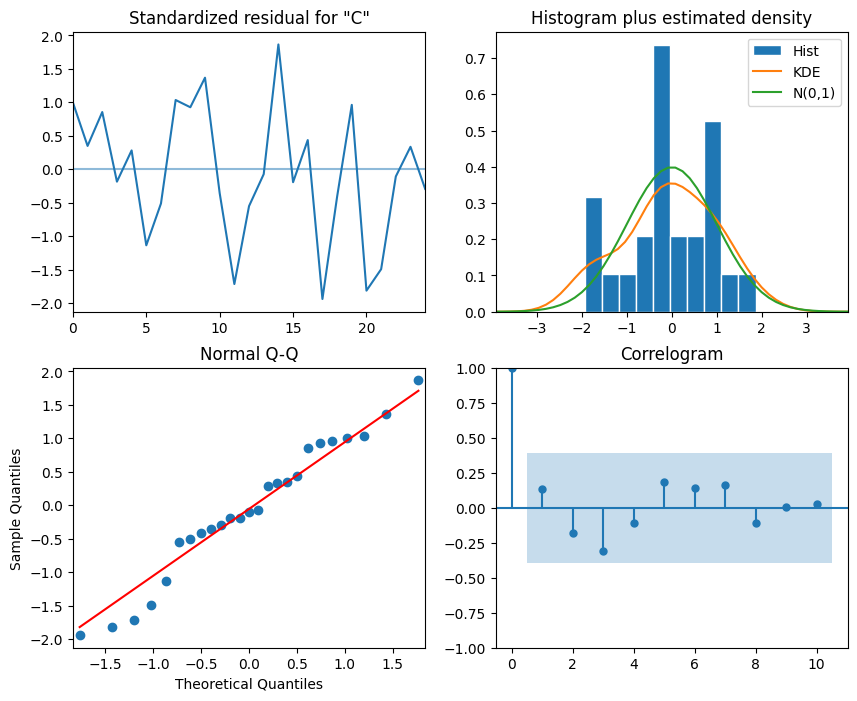

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                  30.373
Date:                            Fri, 30 Jun 2023   AIC                            -54.747
Time:                                    02:04:53   BIC                            -53.052
Sample:                                         0   HQIC                           -55.095
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8986      0.683      1.316      0.188      -0.440       2.237
ar.S.L12      -0.4578      5.799   

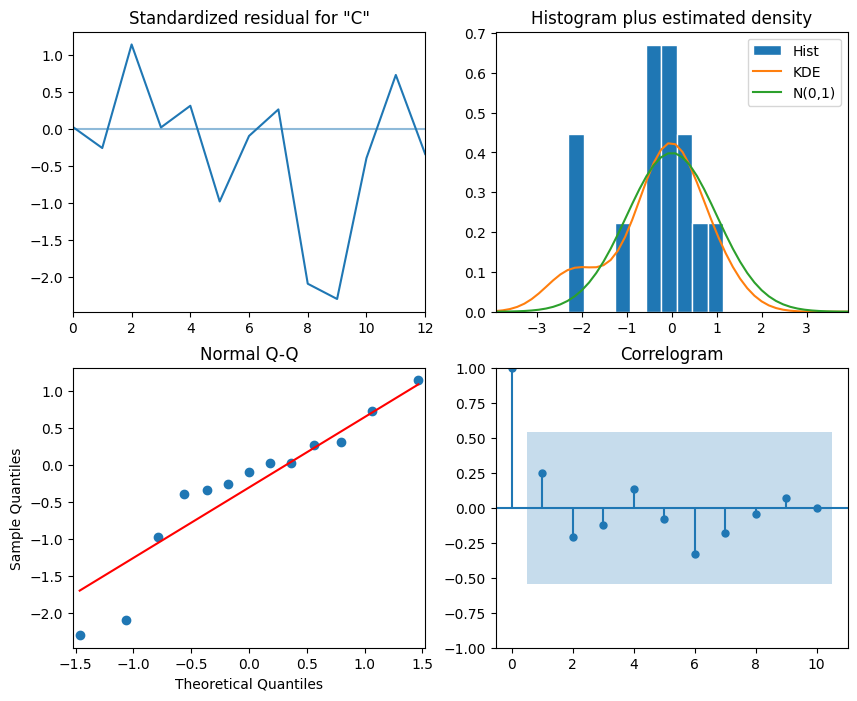

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                  30.362
Date:                              Fri, 30 Jun 2023   AIC                            -52.724
Time:                                      02:04:55   BIC                            -50.464
Sample:                                           0   HQIC                           -53.188
                                               - 25                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9133      0.746      1.224      0.221      -0.549       2.375
ar.S.L12      -0.28

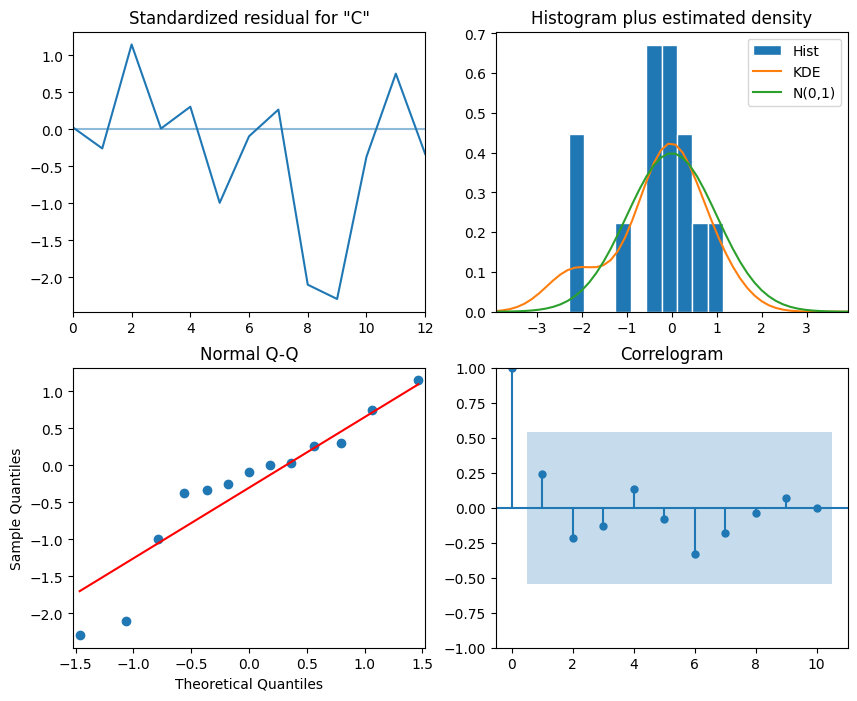

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   25
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  56.590
Date:                Fri, 30 Jun 2023   AIC                           -107.179
Time:                        02:04:56   BIC                           -103.522
Sample:                             0   HQIC                          -106.165
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9995      0.006    162.853      0.000       0.987       1.011
ma.L1          0.1099      0.306      0.359      0.720      -0.491       0.711
sigma2         0.0005      0.000      3.228      0.0

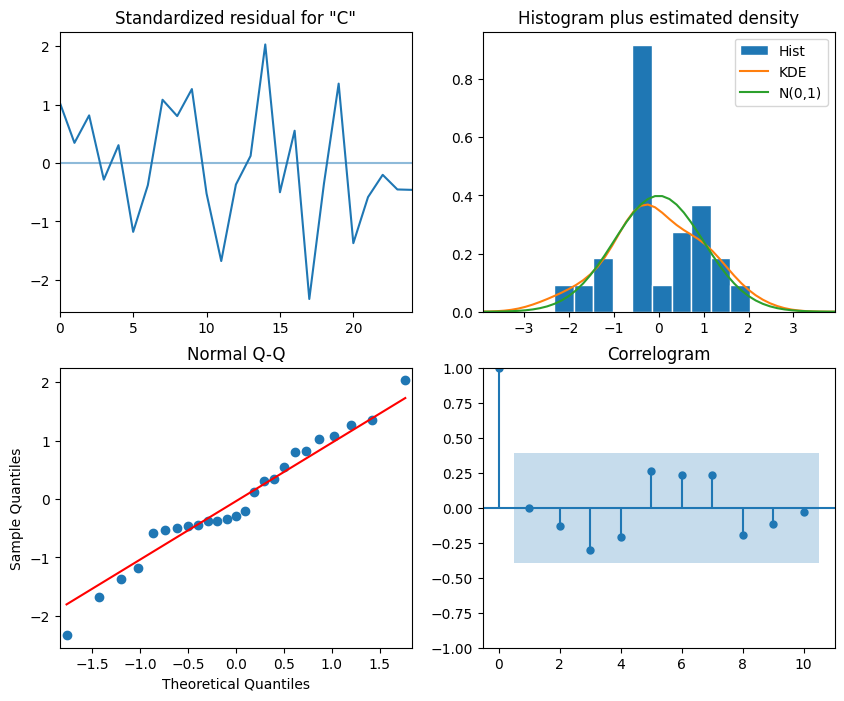

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                  58.169
Date:                            Fri, 30 Jun 2023   AIC                           -108.337
Time:                                    02:04:58   BIC                           -103.462
Sample:                                         0   HQIC                          -106.985
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9986      0.009    115.424      0.000       0.982       1.016
ma.L1          0.2006      0.248   

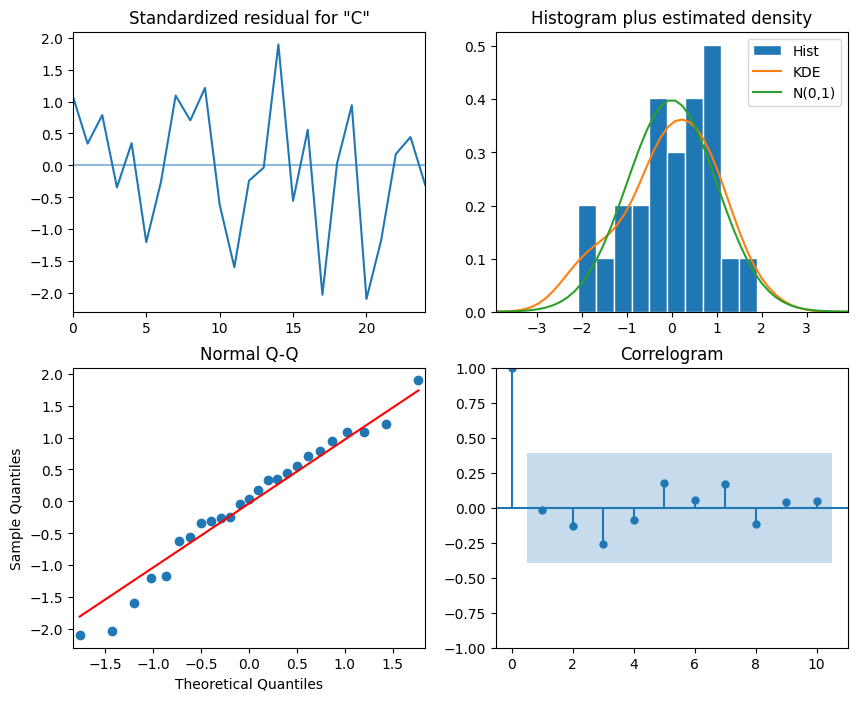

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                  31.271
Date:                             Fri, 30 Jun 2023   AIC                            -56.542
Time:                                     02:05:00   BIC                            -54.847
Sample:                                          0   HQIC                           -56.890
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7555      0.338      2.238      0.025       0.094       1.417
ma.L1          0.4815      

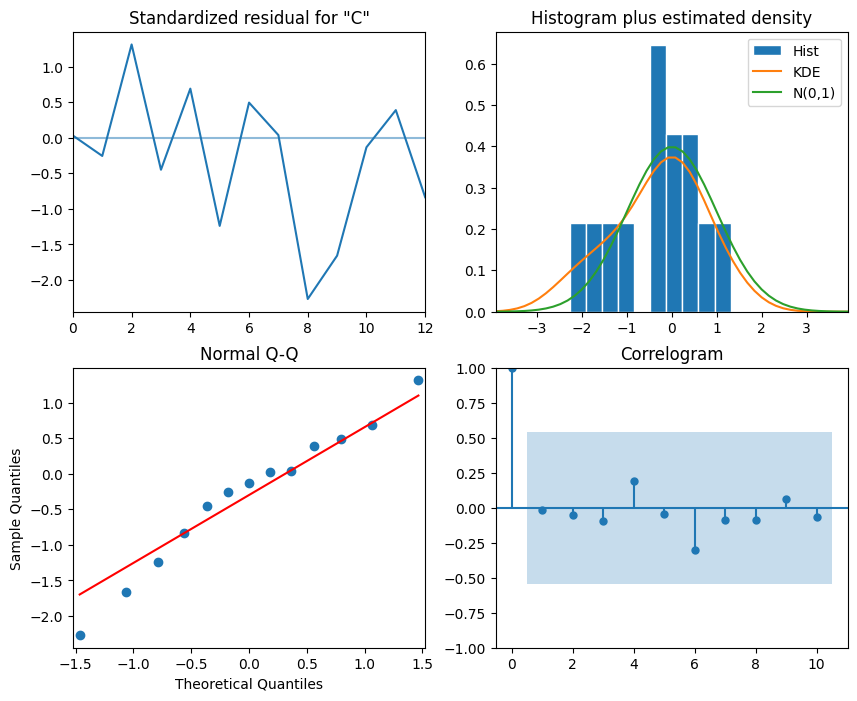

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  31.271
Date:                            Fri, 30 Jun 2023   AIC                            -54.543
Time:                                    02:05:01   BIC                            -52.283
Sample:                                         0   HQIC                           -55.007
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7537      0.361      2.089      0.037       0.046       1.461
ma.L1          0.4888      0.523   

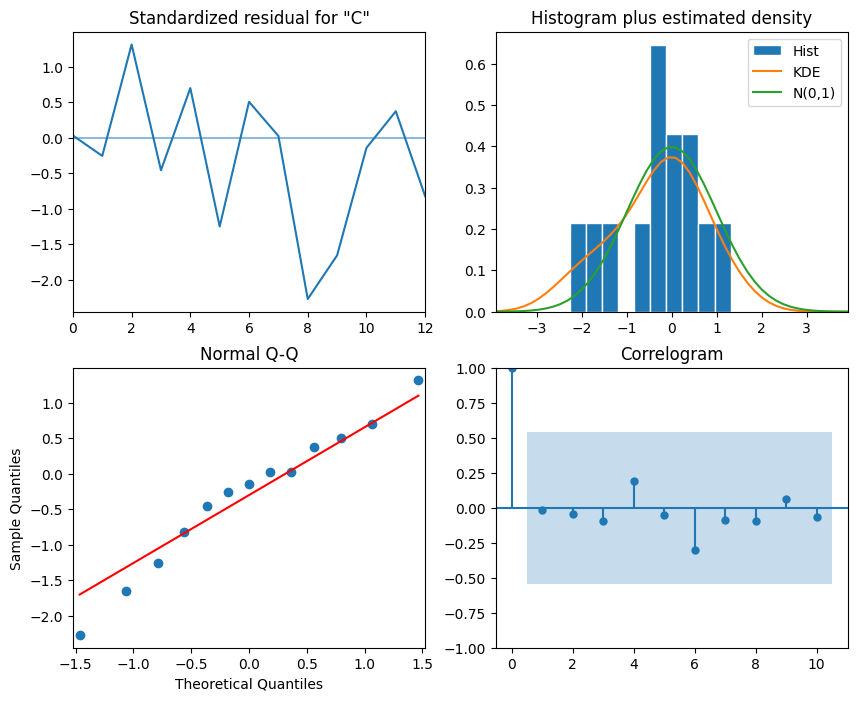

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                  57.958
Date:                             Fri, 30 Jun 2023   AIC                           -107.917
Time:                                     02:05:03   BIC                           -103.041
Sample:                                          0   HQIC                          -106.565
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9945      0.010    100.473      0.000       0.975       1.014
ma.L1          0.2538      

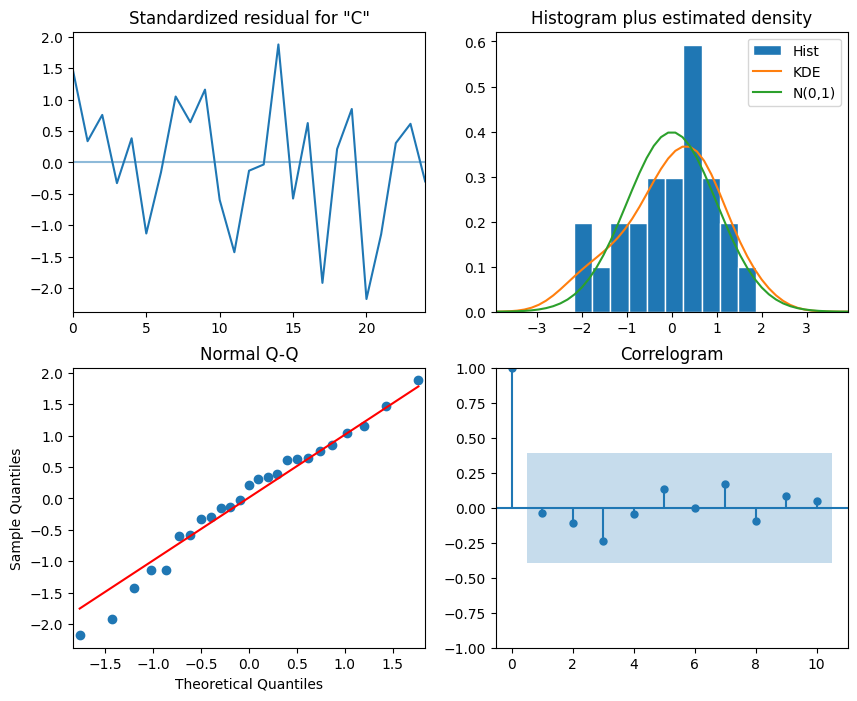

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                  58.239
Date:                            Fri, 30 Jun 2023   AIC                           -106.479
Time:                                    02:05:04   BIC                           -100.384
Sample:                                         0   HQIC                          -104.788
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9959      0.029     33.837      0.000       0.938       1.054
ma.L1          0.1859      0.253   

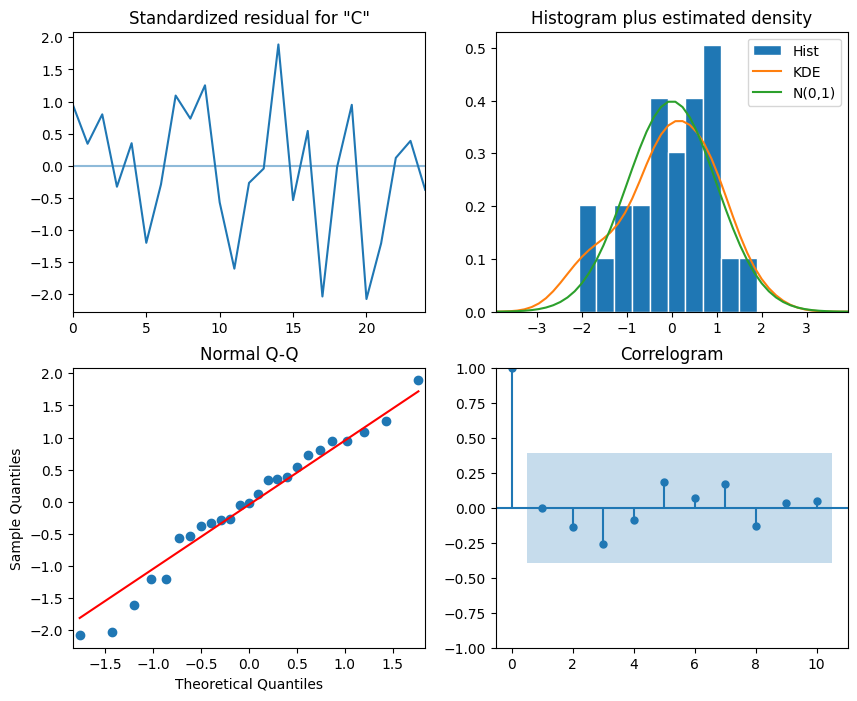

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood                  31.270
Date:                             Fri, 30 Jun 2023   AIC                            -54.539
Time:                                     02:05:06   BIC                            -52.280
Sample:                                          0   HQIC                           -55.004
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7574      0.409      1.851      0.064      -0.045       1.560
ma.L1          0.4778      

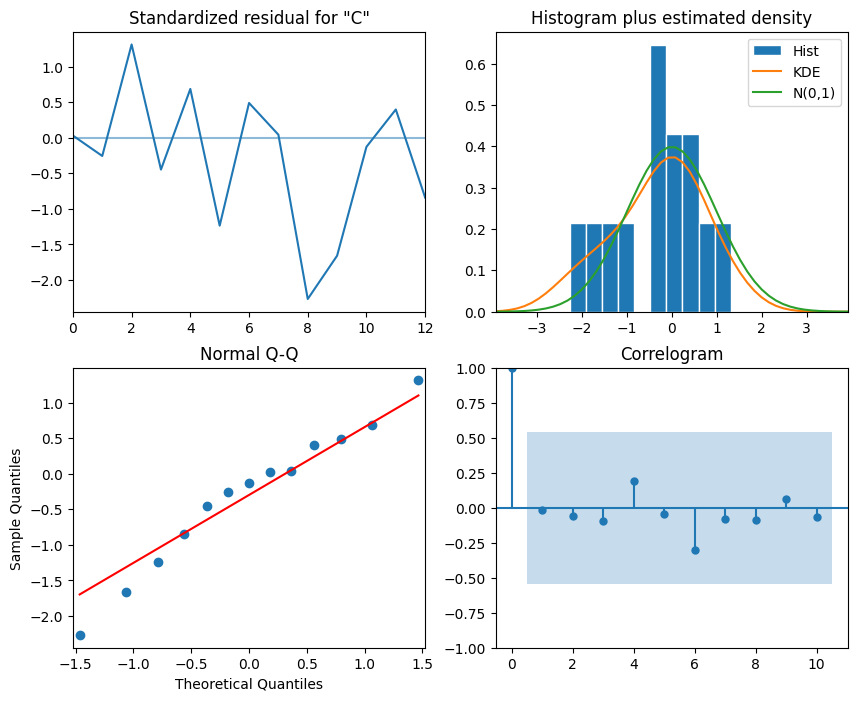

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                  31.271
Date:                            Fri, 30 Jun 2023   AIC                            -52.543
Time:                                    02:05:08   BIC                            -49.718
Sample:                                         0   HQIC                           -53.124
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7536      0.389      1.939      0.053      -0.008       1.515
ma.L1          0.4879      0.527   

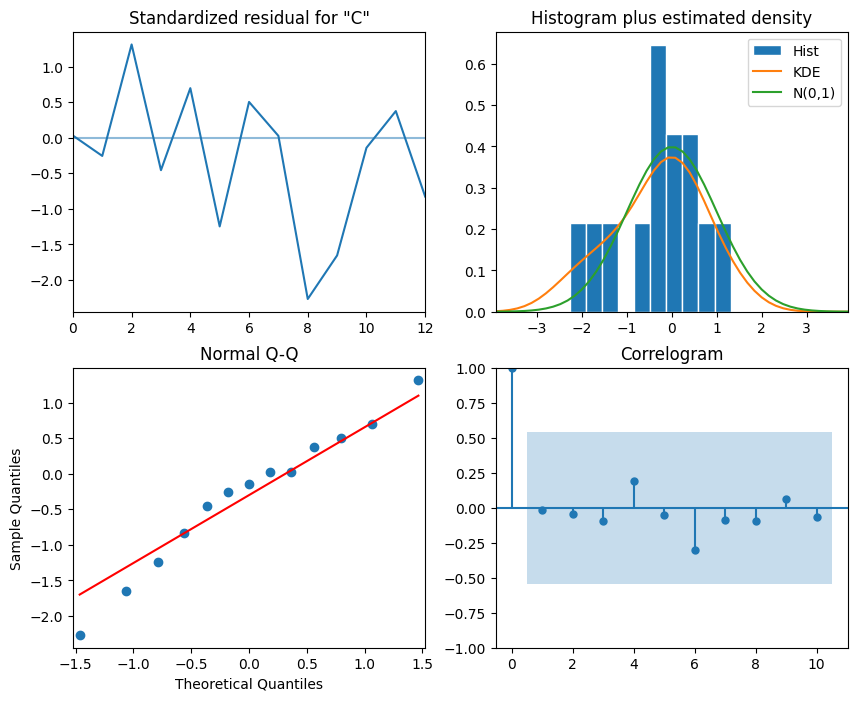

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   25
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  57.659
Date:                Fri, 30 Jun 2023   AIC                           -111.319
Time:                        02:05:09   BIC                           -108.963
Sample:                             0   HQIC                          -110.694
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0803      0.300      0.268      0.789      -0.507       0.668
sigma2         0.0005      0.000      3.207      0.001       0.000       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

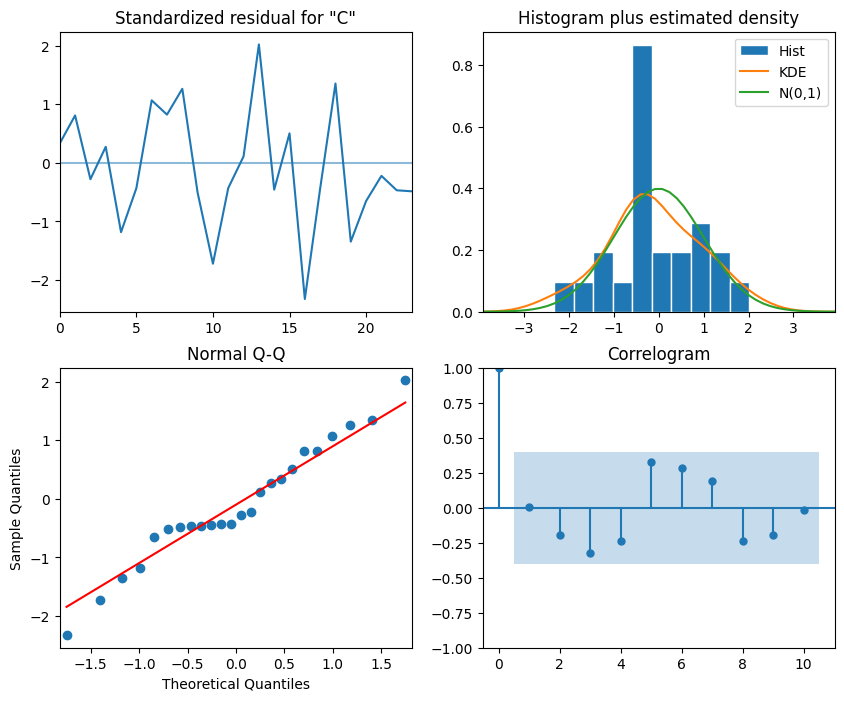

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   25
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 12)   Log Likelihood                  59.062
Date:                              Fri, 30 Jun 2023   AIC                           -112.125
Time:                                      02:05:10   BIC                           -108.591
Sample:                                           0   HQIC                          -111.187
                                               - 25                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0715      0.258      0.276      0.782      -0.435       0.578
ma.S.L12       0.64

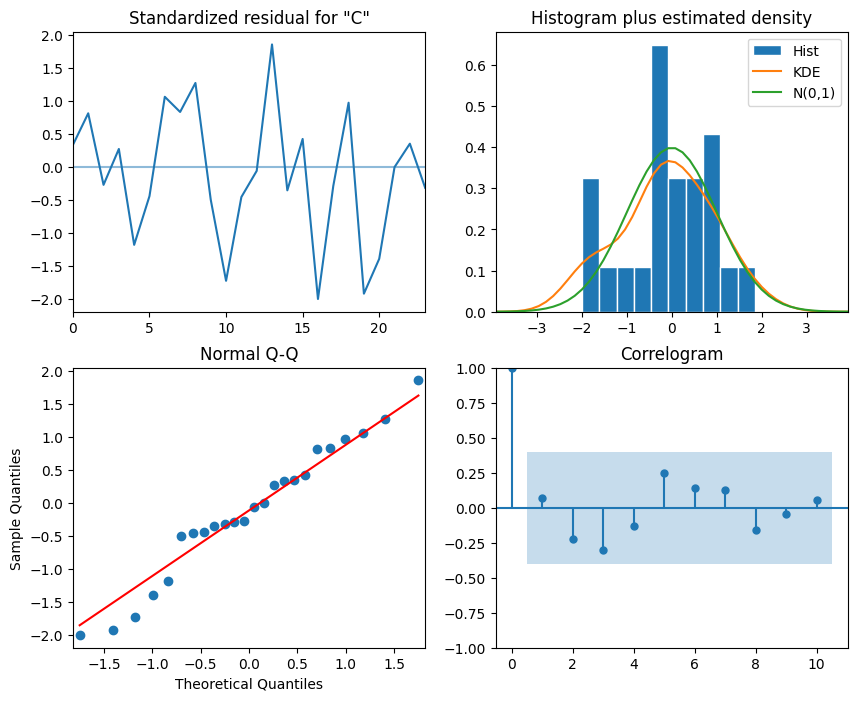

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  28.481
Date:                            Fri, 30 Jun 2023   AIC                            -52.962
Time:                                    02:05:12   BIC                            -51.992
Sample:                                         0   HQIC                           -53.321
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2400      0.290      0.827      0.408      -0.329       0.809
sigma2         0.0005      0.000   

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

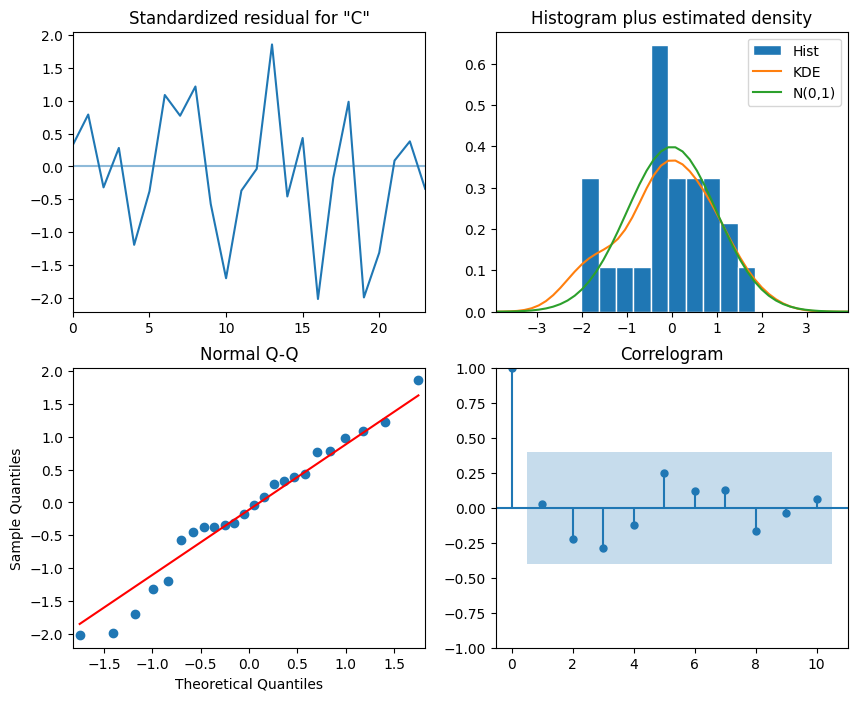

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   25
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                  59.100
Date:                              Fri, 30 Jun 2023   AIC                           -110.201
Time:                                      02:05:14   BIC                           -105.488
Sample:                                           0   HQIC                          -108.951
                                               - 25                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1279      0.265      0.483      0.629      -0.391       0.647
ar.S.L12       0.26

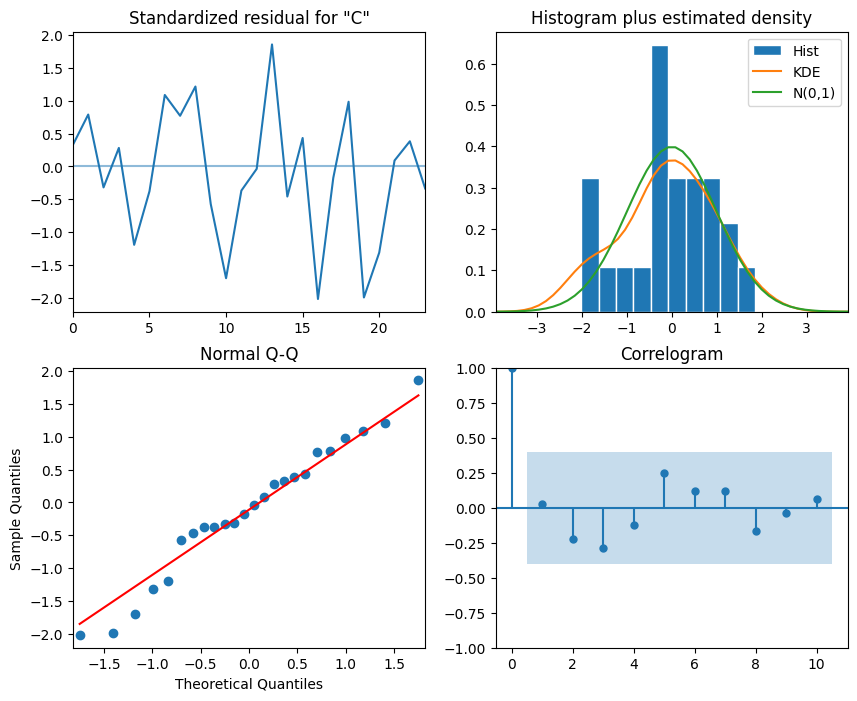

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  28.481
Date:                            Fri, 30 Jun 2023   AIC                            -50.962
Time:                                    02:05:16   BIC                            -49.508
Sample:                                         0   HQIC                           -51.501
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2400      0.290      0.827      0.408      -0.329       0.809
ar.S.L12   -5.104e-07     44.595  -

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

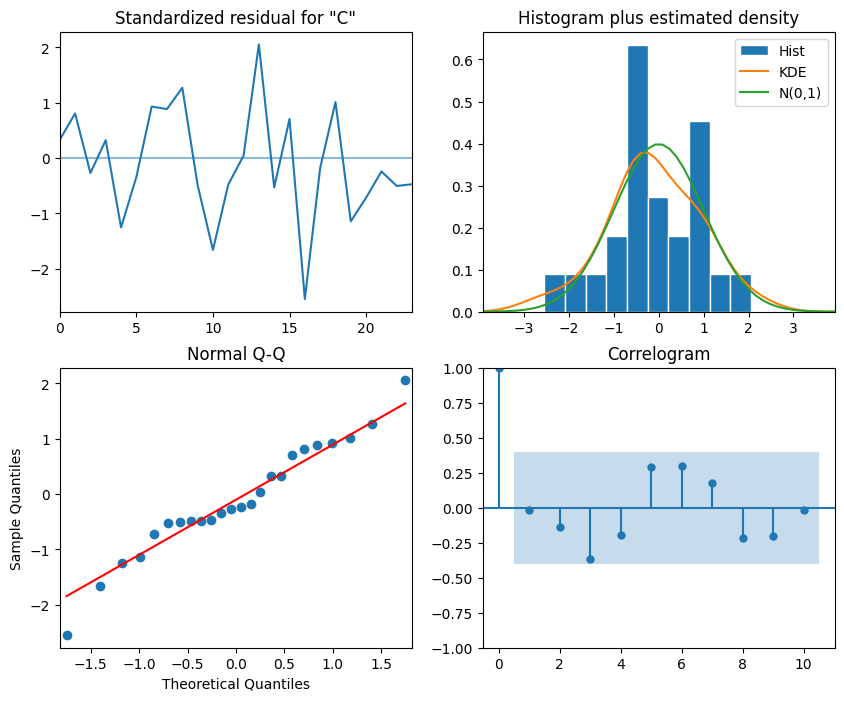

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                  59.364
Date:                            Fri, 30 Jun 2023   AIC                           -110.727
Time:                                    02:05:18   BIC                           -106.015
Sample:                                         0   HQIC                          -109.477
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6217      0.475     -1.309      0.190      -1.552       0.309
ma.L1          0.7767      0.344   

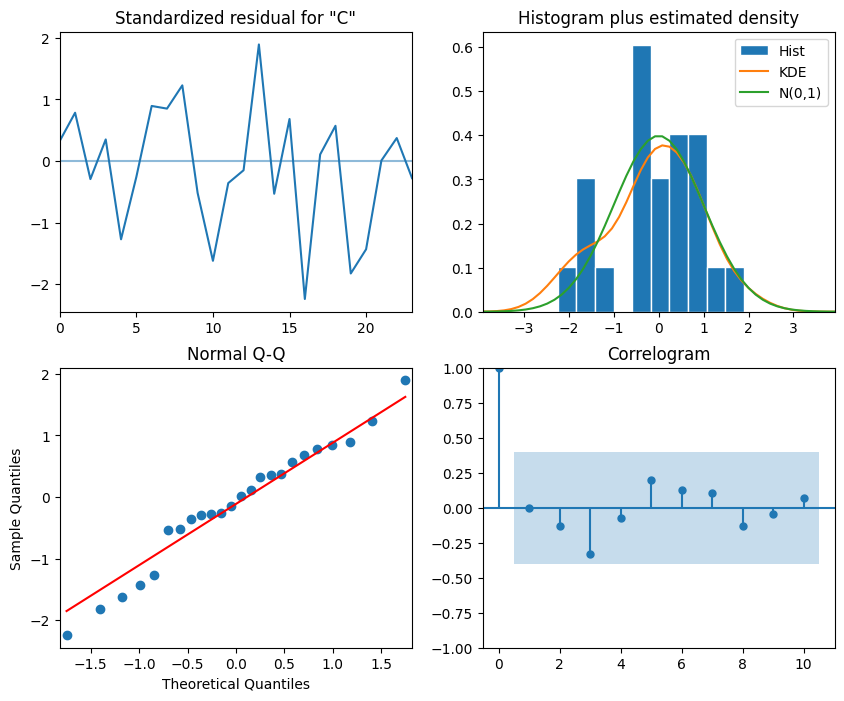

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   25
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                  28.938
Date:                             Fri, 30 Jun 2023   AIC                            -51.876
Time:                                     02:05:19   BIC                            -50.421
Sample:                                          0   HQIC                           -52.415
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3464      0.417     -0.831      0.406      -1.164       0.471
ma.L1          0.7622      

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

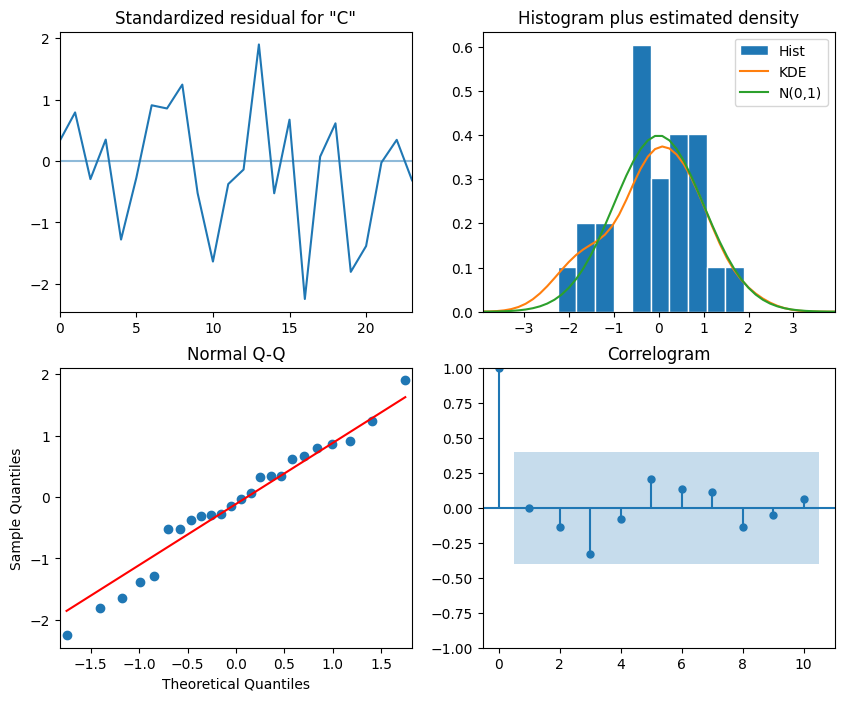

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   25
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                  59.354
Date:                            Fri, 30 Jun 2023   AIC                           -108.708
Time:                                    02:05:22   BIC                           -102.818
Sample:                                         0   HQIC                          -107.145
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6148      0.582     -1.057      0.291      -1.755       0.525
ma.L1          0.7668      0.477   

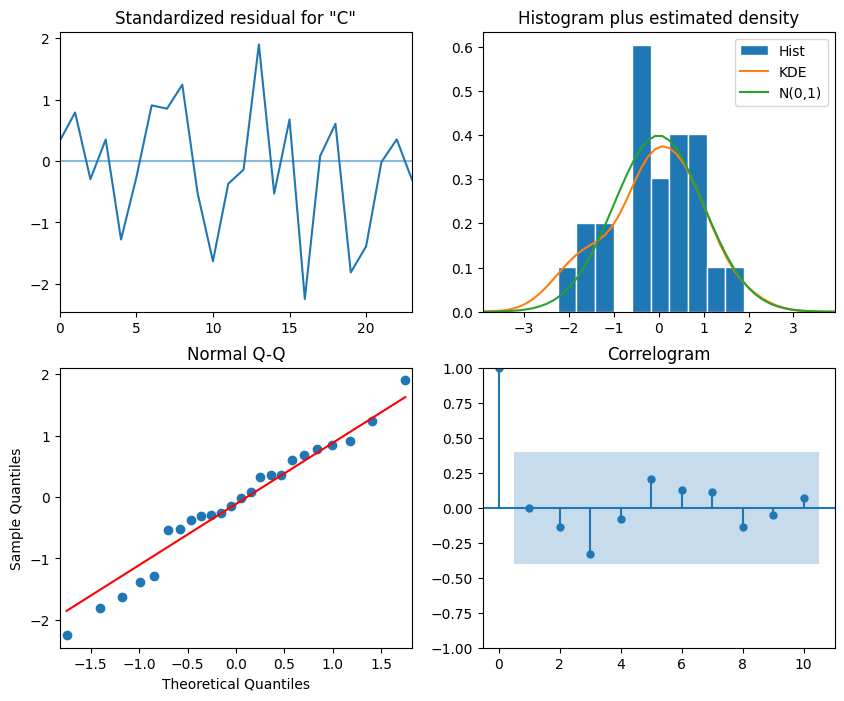

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   25
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                  29.150
Date:                             Fri, 30 Jun 2023   AIC                            -50.300
Time:                                     02:05:24   BIC                            -48.361
Sample:                                          0   HQIC                           -51.019
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3941      0.372     -1.059      0.290      -1.123       0.335
ma.L1          0.7969      

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Define a function for SARIMA model fitting and diagnostics
def fit_sarima(order, seasonal_order):
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    model_fit.plot_diagnostics(figsize=(10, 8))
    plt.show()

# Specify different combinations of parameters to evaluate
p = d = q = range(0, 2)  # Consider AR, I, and MA components in the range [0, 1]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Consider seasonal components with period 12 (months)

# Iterate over combinations and fit SARIMA models
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            fit_sarima(param, param_seasonal)
        except:
            continue

# Print the best model's summary
print("Best Model Summary:")
print(best_model.summary())

Best Model Summary: SARIMAX(1, 0, 1)x(1, 1, 1, 12)

Ljung-Box (L1) (Q): The Ljung-Box statistic is used to test for the presence of autocorrelation in the residuals of a time series model. In this case, L1 refers to the lag 1 autocorrelation. A value of 0.00 suggests that there is no significant autocorrelation at lag 1 in the residuals.

Prob(Q): The probability associated with the Ljung-Box statistic (Q). In this case, the value of 0.94 indicates a high probability that the autocorrelation observed at lag 1 is not statistically significant. This suggests that there is no evidence of residual autocorrelation in the model.

Jarque-Bera (JB): The Jarque-Bera test is used to assess the normality of the residuals in a time series model. The JB statistic is 0.53 in this case, indicating a low value.

Prob(JB): The probability associated with the Jarque-Bera statistic. The value of 0.77 suggests a high probability that the residuals follow a normal distribution. This indicates that the residuals are likely normally distributed.

Heteroskedasticity (H): Heteroskedasticity refers to the unequal variance of the residuals. A value of 1.80 suggests some level of heteroskedasticity in the model's residuals.

Prob(H) (two-sided): The probability associated with the test for heteroskedasticity. The value of 0.58 indicates that there is a high probability that the observed heteroskedasticity is not statistically significant. This suggests that the model's residuals do not exhibit significant heteroskedasticity.

Skew: Skewness is a measure of the asymmetry of the distribution of the residuals. A value of -0.44 suggests a slight left-skewness, indicating that the residuals are somewhat skewed to the left.

Kurtosis: Kurtosis measures the "heaviness" of the tails of the distribution of the residuals. A kurtosis value of 2.56 suggests a moderate level of peakedness in the distribution of the residuals.

`Overall, based on these statistics, it appears that the model's residuals exhibit no significant autocorrelation, are approximately normally distributed, and do not display substantial heteroskedasticity. However, there is a slight left-skewness and a moderate level of peakedness in the distribution of the residuals`.

In [ ]:
model = sm.tsa.statespace.SARIMAX(y_train,
                                             order=(1, 0, 1),
                                             seasonal_order=(1, 1, 1, 12),
                                             #enforce_stationarity=False,
                                             enforce_invertibility=False)
model_aic = model.fit()
print(model_aic.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7545      0.389      1.941      0.052      -0.007       1.516
ma.L1          0.4866      0.526      0.924      0.355      -0.545       1.519
ar.S.L12       0.0478   2825.299   1.69e-05      1.000   -5537.437    5537.532
ma.S.L12      -0.0009   2830.425  -3.28e-07      1.000   -5547.532    5547.531
sigma2         0.0004      0.000      1.670      0.095   -7.22e-05       0.001


ar.L1: The autoregressive coefficient for lag 1 is estimated to be 0.7545. The positive coefficient suggests a positive relationship between the current value and the previous value at lag 1.

ma.L1: The moving average coefficient for lag 1 is estimated to be 0.4866. This coefficient represents the effect of the lagged residual term on the current observation.

ar.S.L12: The seasonal autoregressive coefficient for lag 12 is estimated to be 0.0478. This coefficient captures the seasonal dependence at lag 12, indicating a small positive relationship between the current value and the value at lag 12.

ma.S.L12: The seasonal moving average coefficient for lag 12 is estimated to be -0.0009. This coefficient represents the effect of the seasonal lagged residual term on the current observation at lag 12.

sigma2: The estimated variance of the residuals (error term) is 0.0004. It measures the variability or dispersion of the error term in the model.

The standard errors, z-statistics, and p-values provide information about the statistical significance of the estimated coefficients. A smaller p-value indicates a stronger evidence against the null hypothesis that the coefficient is zero. In this case, some of the coefficients (ar.L1 and ma.L1) have p-values greater than the conventional significance level of 0.05, suggesting that they may not be statistically significant.

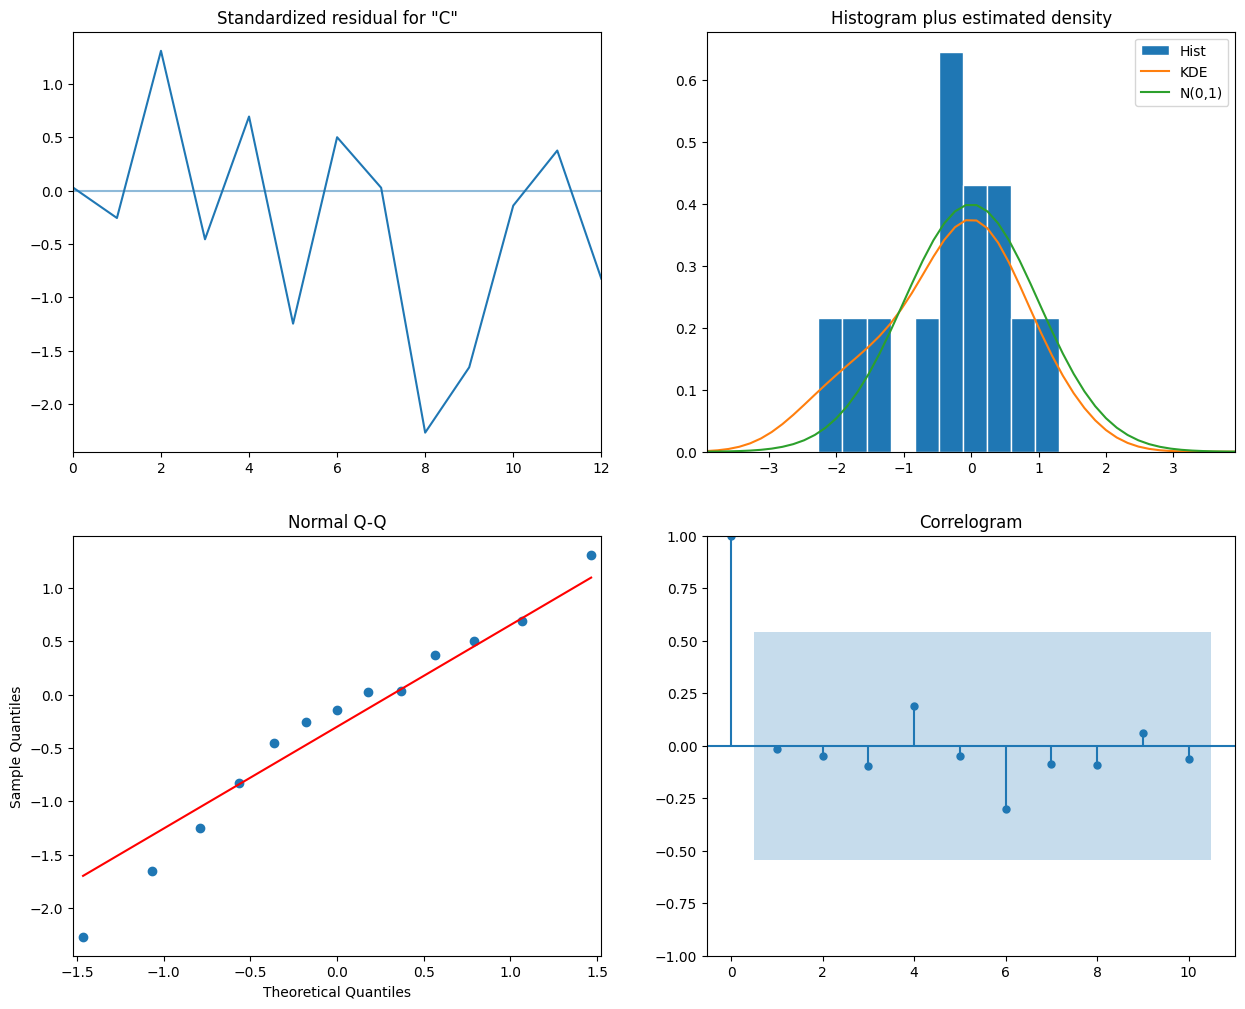

In [ ]:
model_aic.plot_diagnostics(figsize=(15, 12))
plt.show()